In [1]:
import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
from tqdm import tqdm

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (Evolution,
                   prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from gan_train import train_gan
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           visualize_fake_data_projection,
                           discriminator_2d_visualization,
                           mh_sampling_visualize,
                           visualize_potential_energy,
                           langevin_sampling_visualize,
                           mala_sampling_visualize,
                           epoch_visualization)
from mh_2d_sampling import mh_sampling
from ebm_2d_sampling import (langevin_sampling, 
                             mala_sampling)

In [4]:
from sklearn.preprocessing import StandardScaler
random_seed = 42
train_dataset_size = 64000
sigma = 0.05

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [5]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [6]:
discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [7]:
G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

<All keys matched successfully>

In [8]:
epoch = 1000
path_to_save = None
batch_size_sample = 5000  

In [9]:
G = G.to(device)
D = D.to(device)

In [10]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

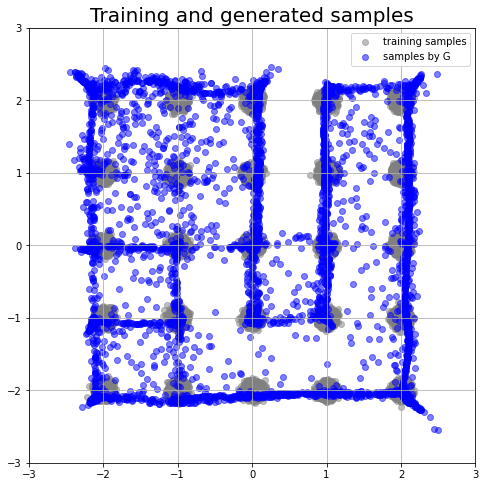

In [11]:
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

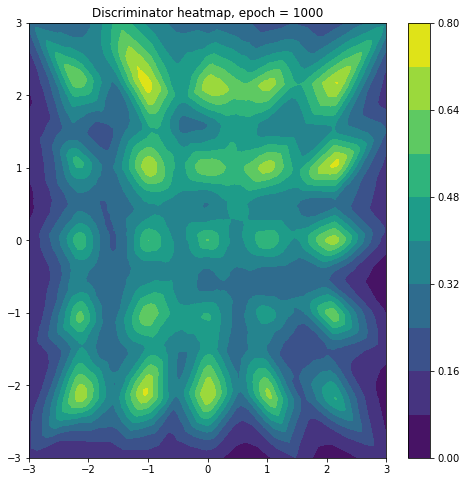

In [19]:
x_range = 3.0
y_range = 3.0
discriminator_2d_visualization(D,
                               x_range,
                               y_range,
                               path_to_save,
                               epoch,
                               scaler = scaler,
                               num_points = 700)

  0%|          | 0/5000 [00:00<?, ?it/s]

Start to do MH sampling....


100%|██████████| 5000/5000 [01:04<00:00, 77.52it/s]


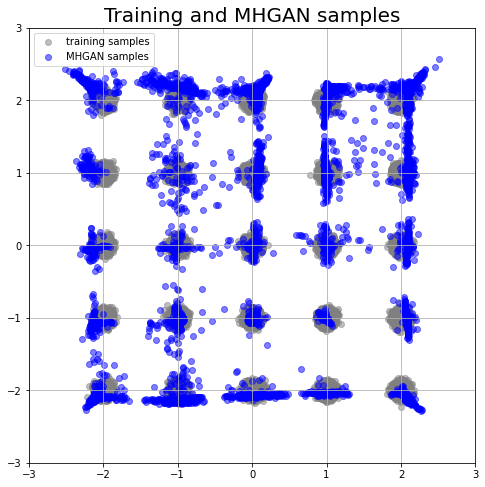

In [12]:
n_calib_pts = 10000
type_calibrator = 'iso'
normalize_to_0_1 = True
mh_sampling_visualize(G, 
                      D,
                      X_train, epoch, 
                      path_to_save,
                      n_calib_pts = n_calib_pts,
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      type_calibrator = type_calibrator,
                      normalize_to_0_1 = normalize_to_0_1)

100%|██████████| 1/1 [00:07<00:00,  7.75s/it]


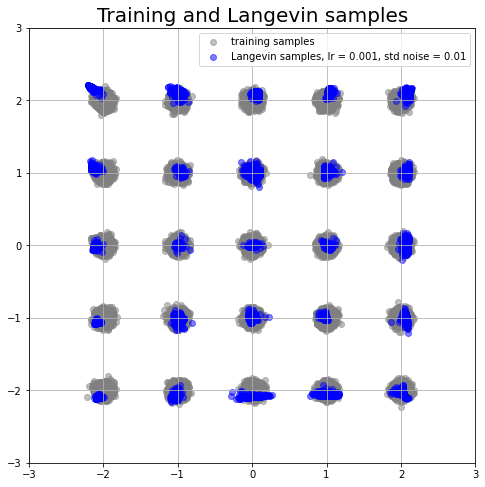

In [12]:
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 5000
n_batches = 1
langevin_sampling_visualize(G, 
                            D,
                            X_train,  
                            path_to_save,
                            alpha = alpha,
                            scaler = scaler, 
                            batch_size_sample = batch_size_sample,
                            path_to_save_remote = None,
                            port_to_remote = None,
                            step_lr = step_lr,
                            eps_std = eps_std,
                            n_steps = n_steps,
                            n_batches = n_batches)

100%|██████████| 1/1 [00:41<00:00, 41.24s/it]


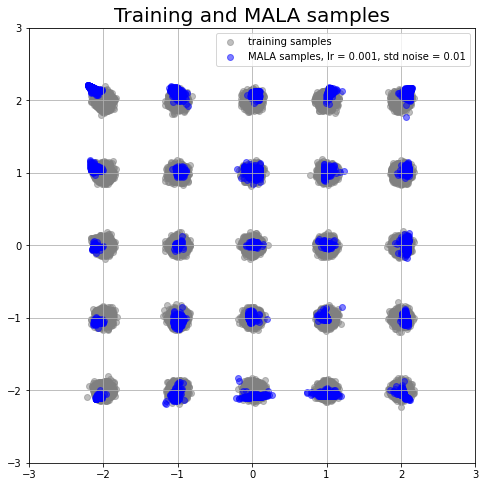

In [256]:
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 5000
n_batches = 1
mala_sampling_visualize(G, 
                        D,
                        X_train,  
                        path_to_save,
                        alpha = alpha,
                        scaler = scaler, 
                        batch_size_sample = batch_size_sample,
                        path_to_save_remote = None,
                        port_to_remote = None,
                        step_lr = step_lr,
                        eps_std = eps_std,
                        n_steps = n_steps,
                        n_batches = n_batches)

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


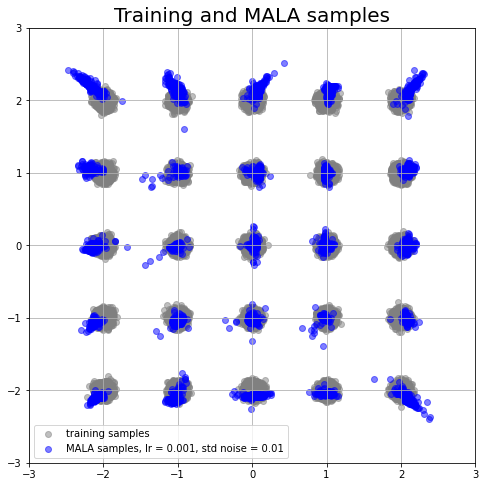

In [70]:
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 50
n_batches = 1
mala_sampling_visualize(G, 
                        D,
                        X_train,  
                        path_to_save,
                        alpha = alpha,
                        scaler = scaler, 
                        batch_size_sample = batch_size_sample,
                        path_to_save_remote = None,
                        port_to_remote = None,
                        step_lr = step_lr,
                        eps_std = eps_std,
                        n_steps = n_steps,
                        n_batches = n_batches)

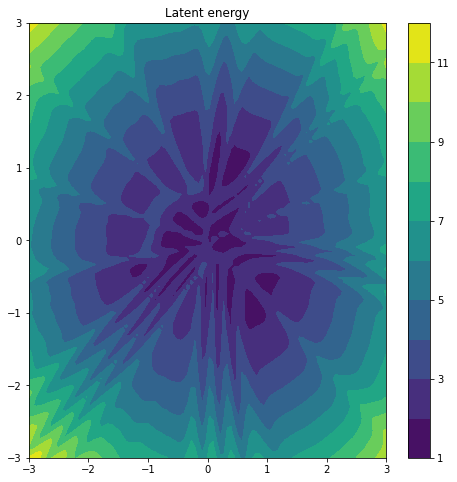

In [17]:
x_range = 3.0
y_range = 3.0
norm_grads = False
normalize_to_0_1 = True
path_to_save = None
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range,
                           path_to_save = path_to_save,
                           norm_grads = norm_grads,
                           normalize_to_0_1 = normalize_to_0_1,
                           num_points = 100)

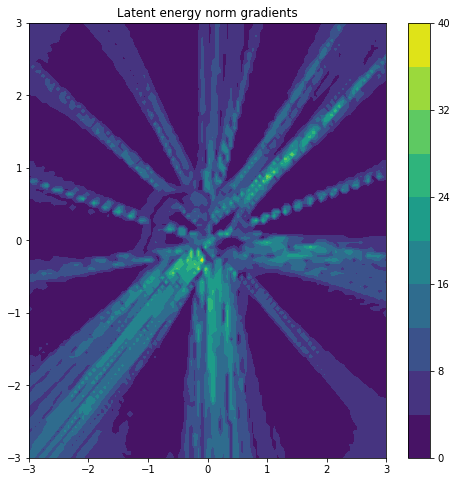

In [18]:
x_range = 3.0
y_range = 3.0
norm_grads = True
normalize_to_0_1 = True
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range,
                           norm_grads = norm_grads,
                           normalize_to_0_1 =normalize_to_0_1)

# X-Try MALA

In [46]:
def e_grad(z, P, gen, dis, alpha, ret_e=False, e_batch=False):
    logp_z = torch.sum(P.log_prob(z), dim=1)
    x = gen(z)
    d = dis(x).view(-1)
    E_batch = (-logp_z - alpha * d)
    E = E_batch.sum()
    # E = - alpha * d
    E.backward()
    grad = z.grad
    # prior_grad = chainer.grad((-logp_z, ), (z, ))
    # d_grad = chainer.grad((d, ), (z, ))
    # import pdb
    # pdb.set_trace()
    if (ret_e and not e_batch):
        return E, grad
    elif (ret_e and e_batch):
        return E_batch, grad
    else:
        return grad

def compute_log_weight(first, second, gen, dis, P, alpha, step_lr, eps_std, clip = 50.0):
    #print(first.requires_grad)
    E_first, grad_first = e_grad(first, P, gen, dis, alpha, ret_e=True, e_batch = True)
        
    new_first = first - step_lr * grad_first
    #new_first = new_first.data
    
    E_second, grad_second = e_grad(second, P, gen, dis, alpha, ret_e=True, e_batch = True)
        
    new_second = second - step_lr * grad_second
    new_second = new_second.data
    
    log_energy = E_first - E_second
    vec_1 = (first - new_second)/eps_std
    vec_2 = (second - new_first)/eps_std
    #print(vec_1)
    #print(vec_2)
    
    propose_numerator = P.log_prob(vec_1).sum(dim=1)
    propose_denumerator = P.log_prob(vec_2).sum(dim=1)
    #print(propose_numerator)
    #print(propose_denumerator)

    log_propose_part = propose_numerator - propose_denumerator
    #print(log_propose_part)
    
    log_weight = log_energy + log_propose_part
    #log_weight = torch.clamp(log_weight, -clip, clip)
    #log_weight = log_weight - torch.max(log_weight, 0)[0]

    #weight = torch.exp(log_weight)
    #weight = weight/torch.sum(weight, 0)
    log_weight = log_weight.detach()
    
    return log_weight

In [76]:
def xtry_mala_dynamics(y0, y1, gen, dis, alpha, n_steps, step_lr, eps_std, N):
    y0_arr = [y0.detach().clone()]
    y1_arr = [y1.detach().clone()]
    weights_arr = []
    batch_size, z_dim = y0.shape[0], y0.shape[1]
    loc = torch.zeros(z_dim).to(gen.device)
    scale = torch.ones(z_dim).to(gen.device)
    normal = Normal(loc, scale)

    for _ in tqdm(range(n_steps)):
        #print(f"step = {_}")
        U = torch.randint(high = N, size = (batch_size,)).tolist()
        #print(f"U = {U}")
        #print(f"y1 = {y1}")
        #print(f"y0 = {y0}")
                          
        Z0 = y0.unsqueeze(1).repeat(1, N, 1)
        noise = normal.sample([batch_size, N])
        #print(f"noise = {noise}")
        
        E_g_j, grad_g_j = e_grad(y0, normal, gen, dis, alpha, ret_e=True)
        g_j = y0 - step_lr * grad_g_j
        g_j = g_j.data
        
        g_j_N = g_j.unsqueeze(1).repeat(1, N, 1)
        Z1 = g_j_N + eps_std*noise
        #print(f"Z1 = {Z1}")
        #print(f"Z0 = {Z0}")
        Z1[np.arange(batch_size), U, :] = y0
        #Z1[np.arange(batch_size), U, :] = y0
        #print(f"Z1 = {Z1}")
        
        Z0_batch = Z0.view((batch_size*N, z_dim)).detach().clone()
        Z1_batch = Z1.view((batch_size*N, z_dim)).detach().clone()
        Z0_batch.requires_grad_(True)
        Z1_batch.requires_grad_(True)
        
        log_weight = compute_log_weight(Z0_batch, Z1_batch, gen, dis, normal, alpha, step_lr, eps_std)
        log_weight = log_weight.view((batch_size, N))
        max_logs = torch.max(log_weight, dim = 1)[0].unsqueeze(-1).repeat((1, N))
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim = 1).unsqueeze(-1).repeat((1, N))
        
        weight = weight/sum_weight
        weights_arr.append(weight.detach().clone())
        #print(f"weight = {weight}")
        
        indices = torch.multinomial(weight, 1)
        indices_squeeze = indices.squeeze().tolist()
        #print(f"indices = {indices_squeeze}")
        #indices = indices.repeat(1, z_dim).unsqueeze(1)
        #with torch.no_grad():
        #    y1 = torch.gather(Z1, 1, indices).squeeze()
        #    y1 = y1.data
        #y1.requires_grad_(True)
        y1 = Z1[np.arange(batch_size), indices_squeeze, :]
        y1 = y1.data
        y1.requires_grad_(True)
        y1_arr.append(y1.detach().clone())
        #print(f"y1 = {y1}")
            
        E_y1, grad_y1 = e_grad(y1, normal, gen, dis, alpha, ret_e=True)
        
        noise_U = noise[np.arange(batch_size), U, :]
        #print(f"noise U = {noise_U}")
        y0 = y1 - step_lr * grad_y1 + eps_std*noise_U
        y0 = y0.data
        y0.requires_grad_(True)
        y0_arr.append(y0.detach().clone())
        #print("------------------------")
        
    return y0_arr, y1_arr, weights_arr

In [77]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 500
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)   

y0 = G.make_hidden(batchsize)
y0.requires_grad_(True)
y1 = G.make_hidden(batchsize)
y1.requires_grad_(True)
N = 2

y0_arr, y1_arr, weights = xtry_mala_dynamics(y0 = y0, 
                                             y1 = y1, 
                                             gen = G, 
                                             dis = D, 
                                             alpha = alpha, 
                                             n_steps = n_steps, 
                                             step_lr = step_lr, 
                                             eps_std = eps_std, 
                                             N = N)

100%|██████████| 500/500 [00:12<00:00, 39.95it/s]


In [78]:
weights = torch.stack(weights, dim = 0).squeeze()
first_weight = weights[:, 0].detach().cpu().numpy()
second_weight = weights[:, 1].detach().cpu().numpy()

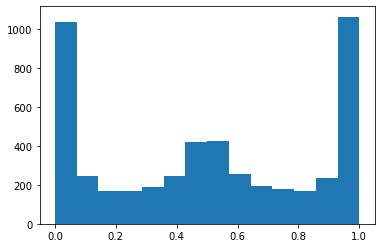

In [70]:
plt.hist(x=first_weight, bins='auto')

In [79]:
y1_last = y1_arr[-1]
y0_last = y0_arr[-1]

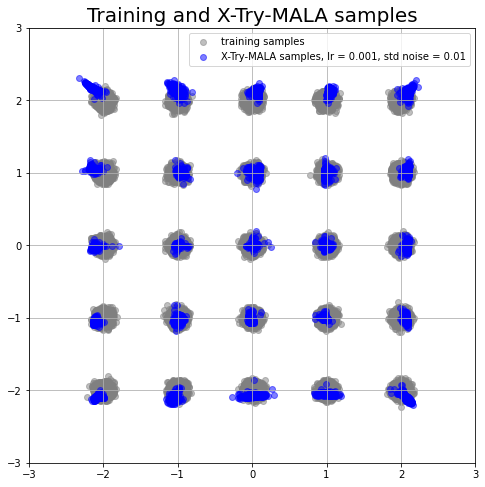

In [80]:
x_try_mala = G(y0_last).data.cpu().numpy()
mode = f'X-Try-MALA'
params = f'lr = {step_lr}, std noise = {eps_std}'
plot_fake_data_mode(x_try_mala, X_train, mode, path_to_save, 
                    scaler = scaler,
                    params = params)

In [133]:
def xtry_mala_dynamics_v2(y0, y1, gen, dis, alpha, n_steps, step_lr, eps_std, N):
    y0_arr = [y0.detach().clone()]
    y1_arr = [y1.detach().clone()]
    batch_size, z_dim = y0.shape[0], y0.shape[1]
    loc = torch.zeros(z_dim).to(gen.device)
    scale = torch.ones(z_dim).to(gen.device)
    normal = Normal(loc, scale)

    for _ in tqdm(range(n_steps)):
        #print(f"step = {_}")
        U_1d = torch.randint(high = N, size = (batch_size,)).to(gen.device)
        U_2d = U_1d.unsqueeze(-1)
        U = U_2d.repeat(1, z_dim).unsqueeze(1)
        #print(U_1d.shape)
                          
        Z0 = y0.unsqueeze(1).repeat(1, N, 1)
        #Z1 = y1.unsqueeze(1).repeat(1, N, 1)
        noise = normal.sample([batch_size, N])
        
        E_g_j, grad_g_j = e_grad(y0, normal, gen, dis, alpha, ret_e=True)
        g_j = y0 - step_lr * grad_g_j
        g_j = g_j.data
        
        g_j_N = g_j.unsqueeze(1).repeat(1, N, 1)
        Z1 = g_j_N + eps_std*noise
        #Z1.scatter_(1, U) = y1
        #y1_big = y1.unsqueeze(1).repeat(1, N, 1)
        #U_scatter = U.repeat(1, N, 1)
        #Z1.scatter_(dim = 1, index = U_scatter, src = y1_big)
        for i in range(batch_size):
            Z1[i][U_1d[i]] = y1[i]
        
        #Z0_batch = Z0.view((batch_size*N, z_dim)).detach().clone()
        #Z1_batch = Z1.view((batch_size*N, z_dim)).detach().clone()
        #Z0_batch.requires_grad_(True)
        #Z1_batch.requires_grad_(True)
        #print(Z0_batch.requires_grad)
        #print(Z1_batch.requires_grad)
        Z1 = Z1.detach()
        Z0 = Z0.detach()
        
        for i in range(batch_size):
            #print(f"num start = {i}")
            first = Z0[i].data
            second = Z1[i].data
            first.requires_grad_(True)
            second.requires_grad_(True)
            
            log_weight = compute_log_weight(first, second, gen, dis, normal, alpha, step_lr, eps_std)
            max_logs = torch.max(log_weight, dim = 0)[0]
            log_weight = log_weight - max_logs
            weight = torch.exp(log_weight)
            sum_weight = torch.sum(weight, dim = 0)

            weight = weight/sum_weight
            #print(f"weight = {weight}")

            indices = torch.multinomial(weight, 1)
            #print(f"indice = {indices}")
            with torch.no_grad():
                y1[i] = Z1[i][indices]

        y1.requires_grad_(True)    
        y1_arr.append(y1.detach().clone())
            
        E_y1, grad_y1 = e_grad(y1, normal, gen, dis, alpha, ret_e=True)
        #noise_U = torch.gather(noise, 1, U).squeeze()   
        noise_U = torch.zeros_like(y1)
        for i in range(batch_size):
            noise_U[i] = noise[i][U_1d[i]]
                          
        y0 = y1 - step_lr * grad_y1 + eps_std*noise_U
        y0 = y0.data
        y0.requires_grad_(True)
        y0_arr.append(y0.detach().clone())
        
    return y0_arr, y1_arr

In [134]:
batchsize = 100
alpha = 1.0
step_lr = 1e-3
eps_std = (2 * step_lr) ** 0.5
n_steps = 500
y0 = G.make_hidden(batchsize)
y0.requires_grad_(True)
y1 = G.make_hidden(batchsize)
y1.requires_grad_(True)
N = 2

y0_arr, y1_arr = xtry_mala_dynamics_v2(y0 = y0, 
                                       y1 = y1, 
                                       gen = G, 
                                       dis = D, 
                                       alpha = alpha, 
                                       n_steps = n_steps, 
                                       step_lr = step_lr, 
                                       eps_std = eps_std, 
                                       N = N)

  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([100])


  0%|          | 1/500 [00:00<02:42,  3.07it/s]

torch.Size([100])


  0%|          | 2/500 [00:00<02:43,  3.05it/s]

torch.Size([100])


  1%|          | 3/500 [00:00<02:41,  3.08it/s]

torch.Size([100])


  1%|          | 4/500 [00:01<02:40,  3.09it/s]

torch.Size([100])


  1%|          | 5/500 [00:01<02:41,  3.06it/s]

torch.Size([100])


  1%|          | 6/500 [00:01<02:43,  3.03it/s]

torch.Size([100])


  1%|▏         | 7/500 [00:02<02:49,  2.91it/s]

torch.Size([100])


  2%|▏         | 8/500 [00:02<02:45,  2.97it/s]

torch.Size([100])


  2%|▏         | 9/500 [00:02<02:43,  3.00it/s]

torch.Size([100])


  2%|▏         | 9/500 [00:03<02:57,  2.76it/s]


KeyboardInterrupt: 

In [131]:
y1_last = y1_arr[-1]
y0_last = y0_arr[-1]

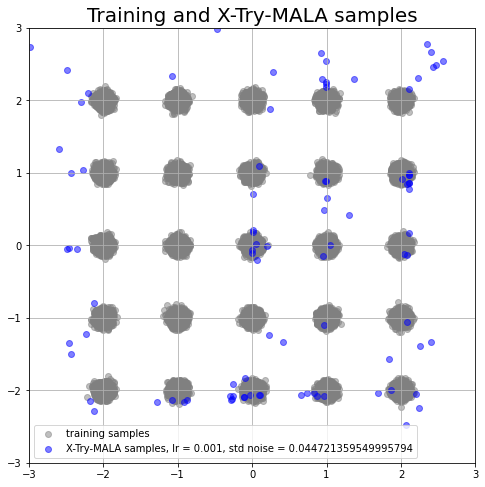

In [132]:
x_try_mala = G(y1_last).data.cpu().numpy()
mode = f'X-Try-MALA'
params = f'lr = {step_lr}, std noise = {eps_std}'
plot_fake_data_mode(x_try_mala, X_train, mode, path_to_save, 
                    scaler = scaler,
                    params = params)

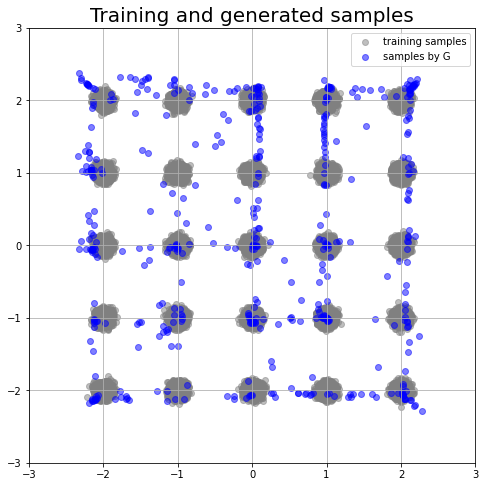

In [107]:
batch_size_sample = 500
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

In [44]:
z_dim = 2
alpha = 1.0
loc = torch.zeros(z_dim).to(G.device)
scale = torch.ones(z_dim).to(G.device)
normal = Normal(loc, scale)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)  
y0 = G.make_hidden(batchsize)
y0.requires_grad_(True)
E_g_j, grad_g_j = e_grad(y0, normal, G, D, alpha, ret_e=True)
g_j = y0 - step_lr * grad_g_j
print(g_j)

tensor([[ 0.2018,  2.1585],
        [-0.1726,  0.8537],
        [-1.9211,  0.6564],
        ...,
        [-1.5153,  0.9121],
        [-0.0581, -0.1243],
        [ 0.7160,  0.1117]], device='cuda:0', grad_fn=<SubBackward0>)


In [113]:
first = torch.tensor([[0.1940, 2.1614],
         [0.1940, 2.1614]]).to(G.device)
second = torch.tensor([[ 0.1391, -0.1082],
         [ 0.2080,  2.1494]]).to(G.device)
first.requires_grad_(True)
second.requires_grad_(True)
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
log_weights = compute_log_weight(first, second, G, D, normal, alpha, step_lr, eps_std)
print(log_weights)

tensor([23.5102, -2.3804], device='cuda:0')


In [114]:
first = torch.tensor([[0.1940, 2.1614]]).to(G.device)
second = torch.tensor([[ 0.1391, -0.1082]]).to(G.device)
first.requires_grad_(True)
second.requires_grad_(True)
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
log_weights = compute_log_weight(first, second, G, D, normal, alpha, step_lr, eps_std)
print(log_weights)

tensor([23.5102], device='cuda:0')


In [118]:
y1 = torch.tensor([[0.1391, -0.1082]]).to(G.device)
y1.requires_grad_(True)
E_y1, grad_y1 = e_grad(y1, normal, G, D, alpha, ret_e=True)
noise = torch.tensor([[-0.0052,  0.0123]]).to(G.device)
y0 = y1 - step_lr * grad_y1 + noise
print(y0)

tensor([[ 0.1331, -0.0922]], device='cuda:0', grad_fn=<AddBackward0>)


In [173]:
batchsize = 10
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 500
random_seed = 39
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)  
y0 = G.make_hidden(batchsize)
y0.requires_grad_(True)
y1 = G.make_hidden(batchsize)
y1.requires_grad_(True)
N = 2

y0_arr, y1_arr = xtry_mala_dynamics_v2(y0 = y0, 
                                       y1 = y1, 
                                       gen = G, 
                                       dis = D, 
                                       alpha = alpha, 
                                       n_steps = n_steps, 
                                       step_lr = step_lr, 
                                       eps_std = eps_std, 
                                       N = N)

  0%|          | 2/500 [00:00<00:28, 17.60it/s]

y1 = tensor([[-0.9364,  0.2438],
        [-0.9677, -0.1776],
        [ 1.3134, -0.0797],
        [ 0.4134, -1.0963],
        [ 1.5268, -0.0736],
        [-0.3123,  0.9615],
        [-1.7525,  1.7578],
        [ 0.2273,  0.8491],
        [ 1.2499,  0.7899],
        [ 1.5165,  2.1262]], device='cuda:0', requires_grad=True)
y0 = tensor([[-0.0101,  0.2648],
        [ 0.2577, -0.5321],
        [-0.2371, -0.3269],
        [-0.0831,  0.0619],
        [-0.9408, -0.2764],
        [ 0.1519,  0.0150],
        [-0.7162,  0.9813],
        [-1.8803, -0.3363],
        [-0.2317, -0.2388],
        [-0.2514, -0.2651]], device='cuda:0', requires_grad=True)
step = 0
y1 = tensor([[-0.9364,  0.2438],
        [-0.9677, -0.1776],
        [ 1.3134, -0.0797],
        [ 0.4134, -1.0963],
        [ 1.5268, -0.0736],
        [-0.3123,  0.9615],
        [-1.7525,  1.7578],
        [ 0.2273,  0.8491],
        [ 1.2499,  0.7899],
        [ 1.5165,  2.1262]], device='cuda:0', requires_grad=True)
y0 = tensor([[-0.0101,

  1%|          | 6/500 [00:00<00:27, 17.83it/s]

weight = tensor([0.2534, 0.7466], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.6867, 0.3133], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([9.9904e-01, 9.6478e-04], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.7223, 0.2777], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.9808, 0.0192], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5355, 0.4645], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.7009, 0.2991], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0124,  0.2594],
        [ 0.2527, -0.5147],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.5177, -0.0783],
        [-0.3123,  0.9615],
        [-1.7525,  1.7578],
        [-1.8646, -0.3584],
        [ 1.2293,  0.7860],
        [-0.3037, -0.2555]],

  2%|▏         | 10/500 [00:00<00:26, 18.71it/s]

Z0 = tensor([[[ 0.0118,  0.2598],
         [ 0.0118,  0.2598]],

        [[ 0.2318, -0.5164],
         [ 0.2318, -0.5164]],

        [[-0.2091, -0.3449],
         [-0.2091, -0.3449]],

        [[ 0.4058, -1.0833],
         [ 0.4058, -1.0833]],

        [[ 1.5116, -0.1025],
         [ 1.5116, -0.1025]],

        [[-0.3176,  0.9494],
         [-0.3176,  0.9494]],

        [[-1.7579,  1.7380],
         [-1.7579,  1.7380]],

        [[-1.8687, -0.3737],
         [-1.8687, -0.3737]],

        [[ 1.2333,  0.7918],
         [ 1.2333,  0.7918]],

        [[-0.2753, -0.2771],
         [-0.2753, -0.2771]]], device='cuda:0', grad_fn=<RepeatBackward>)
num start = 0
weight = tensor([0.1358, 0.8642], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([4.9336e-07, 1.0000e+00], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([8.9309e-06, 9.9999e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tens

  3%|▎         | 14/500 [00:00<00:25, 19.02it/s]

noise_std = tensor([[[-0.0104, -0.0028],
         [ 0.0037, -0.0015]],

        [[-0.0111,  0.0071],
         [ 0.0051,  0.0098]],

        [[ 0.0116,  0.0186],
         [-0.0191, -0.0090]],

        [[-0.0119,  0.0062],
         [-0.0104,  0.0132]],

        [[ 0.0054, -0.0216],
         [ 0.0048, -0.0063]],

        [[ 0.0057, -0.0050],
         [ 0.0047,  0.0036]],

        [[-0.0033,  0.0012],
         [ 0.0061, -0.0046]],

        [[ 0.0171, -0.0059],
         [-0.0059,  0.0050]],

        [[-0.0139, -0.0190],
         [-0.0162,  0.0065]],

        [[ 0.0075, -0.0073],
         [ 0.0005,  0.0004]]], device='cuda:0')
g_j = tensor([[ 0.0178,  0.2591],
        [ 0.2183, -0.5109],
        [-0.2102, -0.3732],
        [ 0.4018, -1.1041],
        [ 1.4868, -0.1007],
        [-0.3092,  0.9604],
        [-1.7585,  1.7377],
        [-1.8449, -0.4061],
        [ 1.2532,  0.7865],
        [-0.2901, -0.2616]], device='cuda:0')
Z1 = tensor([[[ 0.0074,  0.2562],
         [ 0.0242,  0.2716]],

  

  4%|▎         | 18/500 [00:00<00:25, 19.17it/s]

weight = tensor([0.6108, 0.3892], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0166,  0.2473],
        [ 0.2527, -0.5147],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.4984, -0.1046],
        [-0.3188,  0.9473],
        [-1.7654,  1.6937],
        [-1.8646, -0.3584],
        [ 1.2660,  0.7800],
        [-0.2722, -0.2764]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0022, -0.0123],
        [ 0.0124, -0.0068],
        [-0.0105, -0.0100],
        [ 0.0078, -0.0027],
        [ 0.0012, -0.0072],
        [-0.0169,  0.0141],
        [-0.0009, -0.0156],
        [-0.0096,  0.0012],
        [-0.0142,  0.0062],
        [ 0.0065,  0.0026]], device='cuda:0')
y0 = tensor([[ 0.0129,  0.2341],
        [ 0.2480, -0.5213],
        [-0.2198, -0.3607],
        [ 0.4112, -1.0963],
        [ 1.4990, -0.0997],
        [-0.3284,  0.9666],
        [-1.7639,  1.6771],
        [-1.8710, -0.3674],
        [ 1.2506,  0.7854],
        [-0.2806, -0.

  4%|▍         | 22/500 [00:01<00:25, 18.75it/s]

num start = 7
weight = tensor([0.9903, 0.0097], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.3544, 0.6456], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.8687, 0.1313], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0166,  0.2473],
        [ 0.2527, -0.5147],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.4930, -0.1216],
        [-0.3188,  0.9473],
        [-1.7706,  1.6824],
        [-1.8582, -0.3579],
        [ 1.2627,  0.7703],
        [-0.2611, -0.2733]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0068,  0.0121],
        [-0.0235, -0.0076],
        [-0.0038, -0.0128],
        [-0.0086,  0.0187],
        [ 0.0021,  0.0021],
        [ 0.0026,  0.0122],
        [-0.0010,  0.0135],
        [-0.0011, -0.0015],
        [-0.0100,  0.0093],
        [ 0.0050, -0.0096]], device='cuda:0')
y0 = tensor([[ 0.0219,  0.2585],
        [ 0.2121, -0.5221

  5%|▌         | 26/500 [00:01<00:25, 18.24it/s]

num start = 3
weight = tensor([1.9187e-04, 9.9981e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.0205, 0.9795], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.0325, 0.9675], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.7495, 0.2505], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([1.9121e-06, 1.0000e+00], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5008, 0.4992], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.6659, 0.3341], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0166,  0.2473],
        [ 0.2814, -0.5362],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.4930, -0.1216],
        [-0.3019,  0.9409],
        [-1.8140,  1.6610],
        [-1.8582, -0.3579],
        [ 1.2672,  0.7839],
      

  6%|▌         | 28/500 [00:01<00:26, 18.10it/s]

step = 26
y1 = tensor([[ 0.0113,  0.2641],
        [ 0.2814, -0.5362],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.4932, -0.1058],
        [-0.3019,  0.9409],
        [-1.8104,  1.6589],
        [-1.8582, -0.3579],
        [ 1.2334,  0.7592],
        [-0.2469, -0.2349]], device='cuda:0', requires_grad=True)
y0 = tensor([[ 0.0251,  0.2450],
        [ 0.2892, -0.5254],
        [-0.2058, -0.3584],
        [ 0.3876, -1.1018],
        [ 1.4878, -0.1006],
        [-0.2900,  0.9475],
        [-1.7963,  1.6716],
        [-1.8625, -0.3698],
        [ 1.2297,  0.7570],
        [-0.2401, -0.2654]], device='cuda:0', requires_grad=True)
U = 0
noise_std = tensor([[[ 0.0122,  0.0101],
         [ 0.0083,  0.0042]],

        [[-0.0032, -0.0046],
         [ 0.0097, -0.0030]],

        [[ 0.0114, -0.0100],
         [-0.0047,  0.0184]],

        [[-0.0195, -0.0067],
         [ 0.0042, -0.0048]],

        [[ 0.0041,  0.0100],
         [ 0.0004,  0.0298]],

        [[-0.0004,  0.0121

  6%|▋         | 32/500 [00:01<00:25, 18.44it/s]

weight = tensor([5.1032e-05, 9.9995e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.6805, 0.3195], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0848, 0.9152], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0122,  0.2632],
        [ 0.2814, -0.5362],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.4865, -0.0712],
        [-0.3019,  0.9409],
        [-1.7802,  1.6202],
        [-1.8582, -0.3579],
        [ 1.2807,  0.7647],
        [-0.2469, -0.2349]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0143, -0.0158],
        [-0.0060, -0.0050],
        [-0.0017, -0.0104],
        [ 0.0084,  0.0090],
        [ 0.0009, -0.0108],
        [-0.0053, -0.0082],
        [-0.0011, -0.0053],
        [-0.0111,  0.0118],
        [ 0.0002,  0.0028],
        [ 0.0137,  0.0032]], device='cuda:0')
y0 = tensor([[ 0.0252,  0.2393],
        [ 0.2909, -0.5415],
   

  7%|▋         | 36/500 [00:01<00:25, 18.17it/s]

num start = 4
weight = tensor([0.9680, 0.0320], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.9840, 0.0160], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.7719, 0.2281], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([9.9937e-01, 6.2664e-04], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4878, 0.5122], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.8225, 0.1775], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0078,  0.2650],
        [ 0.2814, -0.5362],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.4865, -0.0712],
        [-0.3019,  0.9409],
        [-1.7923,  1.6103],
        [-1.8582, -0.3579],
        [ 1.2845,  0.7616],
        [-0.2469, -0.2349]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0123,  0.0013],
        [ 0

  8%|▊         | 40/500 [00:02<00:26, 17.66it/s]

add noise = tensor([[ 0.0071,  0.0058],
        [-0.0024, -0.0023],
        [-0.0090,  0.0101],
        [ 0.0082, -0.0064],
        [ 0.0216, -0.0017],
        [ 0.0024, -0.0171],
        [ 0.0092, -0.0195],
        [-0.0106, -0.0020],
        [-0.0052, -0.0074],
        [-0.0014, -0.0091]], device='cuda:0')
y0 = tensor([[ 0.0127,  0.2728],
        [ 0.2946, -0.5388],
        [-0.2183, -0.3406],
        [ 0.4116, -1.1000],
        [ 1.5048, -0.0972],
        [-0.2920,  0.9217],
        [-1.7749,  1.5845],
        [-1.8817, -0.3797],
        [ 1.2885,  0.7339],
        [-0.2205, -0.2599]], device='cuda:0', requires_grad=True)
-----------------------
step = 37
y1 = tensor([[ 0.0078,  0.2650],
        [ 0.2814, -0.5362],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.4865, -0.0712],
        [-0.3017,  0.9326],
        [-1.7887,  1.6018],
        [-1.8744, -0.3671],
        [ 1.2950,  0.7420],
        [-0.2368, -0.2248]], device='cuda:0', requires_grad=True)
y0 = tenso

  8%|▊         | 42/500 [00:02<00:25, 18.06it/s]

weight = tensor([0.3919, 0.6081], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.0110, 0.9890], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.3953, 0.6047], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.0030, 0.9970], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.6473, 0.3527], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([2.1377e-05, 9.9998e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0288,  0.2845],
        [ 0.2814, -0.5362],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.4847, -0.1006],
        [-0.2801,  0.9281],
        [-1.7712,  1.6027],
        [-1.8911, -0.3770],
        [ 1.2934,  0.7619],
        [-0.2368, -0.2248]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0010,  0.0162],
        [-0.0015,  0.0144

  9%|▉         | 46/500 [00:02<00:29, 15.55it/s]

indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5371, 0.4629], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0047, 0.9953], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0288,  0.2845],
        [ 0.2814, -0.5362],
        [-0.2288, -0.3309],
        [ 0.4175, -1.0941],
        [ 1.4847, -0.1006],
        [-0.2801,  0.9281],
        [-1.7533,  1.6020],
        [-1.8911, -0.3770],
        [ 1.3027,  0.7558],
        [-0.2368, -0.2248]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0030, -0.0024],
        [-0.0016, -0.0008],
        [-0.0230,  0.0129],
        [-0.0027,  0.0089],
        [-0.0177, -0.0039],
        [-0.0085, -0.0024],
        [-0.0105,  0.0025],
        [-0.0239, -0.0039],
        [-0.0057, -0.0240],
        [ 0.0161,  0.0027]], device='cuda:0')
y0 = tensor([[ 0.0305,  0.2872],
        [ 0.2954, -0.5373],
        [-0.2324, -0.3378],
        [ 0.4007, -1.0847],
      

 10%|█         | 50/500 [00:02<00:26, 16.89it/s]

num start = 5
weight = tensor([0.9536, 0.0464], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.4893, 0.5107], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.9987, 0.0013], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4071, 0.5929], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.6205, 0.3795], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0369,  0.2973],
        [ 0.2814, -0.5362],
        [-0.2174, -0.3537],
        [ 0.4175, -1.0941],
        [ 1.4758, -0.0933],
        [-0.2715,  0.9259],
        [-1.7950,  1.6115],
        [-1.8911, -0.3770],
        [ 1.2897,  0.7593],
        [-0.2361, -0.2190]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0017,  0.0084],
        [ 0.0029, -0.0134],
        [-0.0152,  0.0073],
        [ 0.0112, -0.0045],
        [ 0.0043, -0.0072],
        [-

 10%|█         | 52/500 [00:02<00:26, 16.61it/s]

weight = tensor([0.9463, 0.0537], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 1
weight = tensor([1.0000e+00, 3.4628e-07], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.5283, 0.4717], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([0.9841, 0.0159], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.6201, 0.3799], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.9240, 0.0760], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.6604, 0.3396], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.9988, 0.0012], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.6704, 0.3296], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([9.9998e-01, 2.4524e-05], device='cuda:0')
indice

 11%|█         | 56/500 [00:03<00:25, 17.12it/s]

indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.5801, 0.4199], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.9801, 0.0199], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5791, 0.4209], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([9.9997e-01, 2.7115e-05], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0369,  0.2973],
        [ 0.2814, -0.5362],
        [-0.1777, -0.3617],
        [ 0.4175, -1.0941],
        [ 1.4699, -0.0924],
        [-0.2585,  0.9325],
        [-1.7950,  1.6115],
        [-1.8911, -0.3770],
        [ 1.2730,  0.7572],
        [-0.2306, -0.2205]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0156,  0.0070],
        [-0.0040,  0.0042],
        [-0.0075,  0.0139],
        [-0.0071,  0.0004],
        [ 0.0045, -0.0112],
        [-0.0143, -0.0083],
        [-0.0173, -0.0021],
        [ 0

 12%|█▏        | 60/500 [00:03<00:24, 17.75it/s]

weight = tensor([0.0096, 0.9904], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.3510, 0.6490], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([0.0027, 0.9973], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.2082, 0.7918], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.6079, 0.3921], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.1642, 0.8358], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.0044, 0.9956], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.2621, 0.7379], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.4924, 0.5076], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0369,  0.2973],
        [ 0.2814, -0.5362],
        [-0.1736, -0.3513]

 13%|█▎        | 64/500 [00:03<00:23, 18.37it/s]

y0 = tensor([[ 0.0314,  0.3478],
        [ 0.3041, -0.5289],
        [-0.1883, -0.3394],
        [ 0.3973, -1.0901],
        [ 1.4920, -0.0946],
        [-0.1839,  0.9364],
        [-1.8083,  1.6409],
        [-1.9080, -0.3738],
        [ 1.2301,  0.7457],
        [-0.2410, -0.2487]], device='cuda:0', requires_grad=True)
U = 1
noise_std = tensor([[[-0.0014,  0.0065],
         [-0.0051, -0.0045]],

        [[ 0.0079,  0.0036],
         [ 0.0077,  0.0008]],

        [[-0.0102,  0.0039],
         [-0.0024, -0.0071]],

        [[ 0.0174, -0.0112],
         [ 0.0138, -0.0036]],

        [[ 0.0163,  0.0040],
         [-0.0001,  0.0057]],

        [[-0.0018, -0.0036],
         [ 0.0010,  0.0136]],

        [[-0.0098,  0.0049],
         [-0.0065, -0.0013]],

        [[-0.0080,  0.0018],
         [ 0.0069, -0.0088]],

        [[ 0.0164, -0.0078],
         [ 0.0164, -0.0034]],

        [[-0.0131,  0.0141],
         [ 0.0047, -0.0043]]], device='cuda:0')
g_j = tensor([[ 0.0339,  0.3480],
        

 14%|█▎        | 68/500 [00:03<00:24, 17.53it/s]

num start = 7
weight = tensor([0.0022, 0.9978], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5810, 0.4190], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([7.0379e-07, 1.0000e+00], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0325,  0.3546],
        [ 0.2814, -0.5362],
        [-0.1881, -0.3073],
        [ 0.4217, -1.1129],
        [ 1.4907, -0.0926],
        [-0.1971,  0.9286],
        [-1.8218,  1.6371],
        [-1.9126, -0.3826],
        [ 1.2452,  0.7372],
        [-0.2375, -0.2251]], device='cuda:0', requires_grad=True)
add noise = tensor([[-2.8132e-06, -1.2806e-02],
        [ 3.4763e-03, -6.4929e-03],
        [-1.8412e-02, -1.5798e-02],
        [ 3.3322e-03,  1.6731e-02],
        [-4.3795e-03, -1.4213e-02],
        [ 5.0756e-03,  5.3998e-03],
        [ 4.3789e-03, -5.5051e-03],
        [-1.2732e-02, -5.9189e-03],
        [ 3.8789e-04, -1.4423e-03],
        [ 8.9351e-03,  1

 14%|█▍        | 72/500 [00:04<00:23, 18.40it/s]

Z1 = tensor([[[ 0.0356,  0.3570],
         [ 0.0369,  0.3634]],

        [[ 0.3182, -0.5532],
         [ 0.2814, -0.5362]],

        [[-0.1863, -0.3410],
         [-0.1881, -0.3073]],

        [[ 0.3940, -1.0972],
         [ 0.4217, -1.1129]],

        [[ 1.5016, -0.1054],
         [ 1.5069, -0.0904]],

        [[-0.2108,  0.9690],
         [-0.1794,  0.9705]],

        [[-1.8173,  1.6426],
         [-1.8218,  1.6371]],

        [[-1.9283, -0.3991],
         [-1.9126, -0.3826]],

        [[ 1.2567,  0.7205],
         [ 1.2470,  0.7251]],

        [[-0.1954, -0.2282],
         [-0.1966, -0.1991]]], device='cuda:0', grad_fn=<CopySlices>)
Z0 = tensor([[[ 0.0406,  0.3595],
         [ 0.0406,  0.3595]],

        [[ 0.2982, -0.5464],
         [ 0.2982, -0.5464]],

        [[-0.1600, -0.3307],
         [-0.1600, -0.3307]],

        [[ 0.4039, -1.1071],
         [ 0.4039, -1.1071]],

        [[ 1.4966, -0.1086],
         [ 1.4966, -0.1086]],

        [[-0.2151,  0.9656],
         [-0.2151,  0.

 15%|█▍        | 74/500 [00:04<00:23, 18.49it/s]

y0 = tensor([[ 0.0303,  0.3676],
        [ 0.2918, -0.5336],
        [-0.1879, -0.3488],
        [ 0.4036, -1.1276],
        [ 1.4979, -0.1191],
        [-0.2507,  0.9608],
        [-1.8133,  1.6327],
        [-1.8957, -0.4084],
        [ 1.2467,  0.6920],
        [-0.1946, -0.2025]], device='cuda:0', requires_grad=True)
U = 1
noise_std = tensor([[[ 0.0074, -0.0235],
         [ 0.0032, -0.0061]],

        [[-0.0072, -0.0134],
         [-0.0045,  0.0077]],

        [[-0.0137,  0.0139],
         [ 0.0133,  0.0066]],

        [[ 0.0014, -0.0138],
         [-0.0056,  0.0135]],

        [[-0.0127,  0.0084],
         [-0.0018,  0.0180]],

        [[ 0.0032, -0.0003],
         [ 0.0060,  0.0207]],

        [[-0.0025,  0.0089],
         [-0.0018,  0.0044]],

        [[ 0.0141, -0.0073],
         [-0.0019, -0.0108]],

        [[-0.0033, -0.0168],
         [-0.0103, -0.0045]],

        [[ 0.0148, -0.0022],
         [ 0.0027, -0.0008]]], device='cuda:0')
g_j = tensor([[ 0.0284,  0.3689],
        

 16%|█▌        | 78/500 [00:04<00:25, 16.61it/s]

weight = tensor([1.0000e+00, 6.5747e-07], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0557,  0.3139],
        [ 0.2814, -0.5362],
        [-0.1524, -0.3275],
        [ 0.4201, -1.1265],
        [ 1.5062, -0.1036],
        [-0.2468,  0.9706],
        [-1.8218,  1.6407],
        [-1.9126, -0.3826],
        [ 1.2421,  0.6746],
        [-0.1726, -0.2317]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0094,  0.0039],
        [-0.0112,  0.0023],
        [-0.0068, -0.0031],
        [-0.0002,  0.0054],
        [-0.0089, -0.0148],
        [-0.0020, -0.0064],
        [ 0.0025, -0.0061],
        [ 0.0209,  0.0053],
        [ 0.0012,  0.0019],
        [ 0.0117,  0.0121]], device='cuda:0')
y0 = tensor([[ 0.0608,  0.3278],
        [ 0.2857, -0.5342],
        [-0.1778, -0.3204],
        [ 0.4058, -1.1207],
        [ 1.4963, -0.1101],
        [-0.2461,  0.9667],
        [-1.8162,  1.6348],
        [-1.8877, -0.3907],
        [ 1.2421,  0.6758],
        [-0.1

 16%|█▋        | 82/500 [00:04<00:24, 17.06it/s]

weight = tensor([0.4473, 0.5527], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.2488, 0.7512], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([6.1999e-04, 9.9938e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.6039, 0.3961], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([1.1380e-05, 9.9999e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0502,  0.3453],
        [ 0.2814, -0.5362],
        [-0.1608, -0.3227],
        [ 0.4201, -1.1265],
        [ 1.5062, -0.1036],
        [-0.2468,  0.9706],
        [-1.7825,  1.6354],
        [-1.9006, -0.3930],
        [ 1.2451,  0.6928],
        [-0.1726, -0.2317]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0080,  0.0093],
        [-0.0075, -0.0003],
        [-0.0117,  0.0044],
        [ 0.0033, -0.0160],
        [-0.0059,  0.0060],
        

 17%|█▋        | 84/500 [00:04<00:24, 17.18it/s]

weight = tensor([0.0059, 0.9941], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([0.0012, 0.9988], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.7598, 0.2402], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([0.0064, 0.9936], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.6762, 0.3238], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.5631, 0.4369], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.2777, 0.7223], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.0153, 0.9847], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4887, 0.5113], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.4305, 0.5695], device='cuda:0')
indice = tensor([1], d

 18%|█▊        | 88/500 [00:04<00:22, 17.97it/s]

add noise = tensor([[ 0.0106,  0.0027],
        [ 0.0026, -0.0169],
        [-0.0011, -0.0135],
        [ 0.0131,  0.0121],
        [-0.0090, -0.0072],
        [-0.0104,  0.0048],
        [ 0.0100, -0.0066],
        [ 0.0090, -0.0178],
        [ 0.0166, -0.0089],
        [-0.0145,  0.0127]], device='cuda:0')
y0 = tensor([[ 0.0668,  0.3829],
        [ 0.2995, -0.5535],
        [-0.1502, -0.3101],
        [ 0.4191, -1.1140],
        [ 1.4968, -0.1004],
        [-0.2510,  0.9767],
        [-1.7713,  1.6277],
        [-1.8878, -0.4227],
        [ 1.2551,  0.6453],
        [-0.2108, -0.1792]], device='cuda:0', requires_grad=True)
-----------------------
step = 86
y1 = tensor([[ 0.0506,  0.3826],
        [ 0.2814, -0.5362],
        [-0.1390, -0.2981],
        [ 0.4201, -1.1265],
        [ 1.5065, -0.1046],
        [-0.2425,  0.9696],
        [-1.7838,  1.6349],
        [-1.9006, -0.3930],
        [ 1.2397,  0.6548],
        [-0.1794, -0.2097]], device='cuda:0', requires_grad=True)
y0 = tenso

 18%|█▊        | 92/500 [00:05<00:22, 18.11it/s]

indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.7719, 0.2281], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0506,  0.3826],
        [ 0.2814, -0.5362],
        [-0.1603, -0.2858],
        [ 0.4201, -1.1265],
        [ 1.5296, -0.0835],
        [-0.2251,  0.9486],
        [-1.7723,  1.6285],
        [-1.9006, -0.3930],
        [ 1.2376,  0.6600],
        [-0.1794, -0.2097]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0004, -0.0085],
        [ 0.0031,  0.0022],
        [-0.0028, -0.0066],
        [ 0.0042, -0.0018],
        [-0.0050, -0.0205],
        [ 0.0259, -0.0142],
        [ 0.0068, -0.0067],
        [-0.0027, -0.0152],
        [-0.0084, -0.0037],
        [-0.0029, -0.0071]], device='cuda:0')
y0 = tensor([[ 0.0558,  0.3716],
        [ 0.3001, -0.5344],
        [-0.1487, -0.3084],
        [ 0.4102, -1.1278],
        [ 1.5217, -0.1227],
        [-0.1982,  0.9375],
        [-1.7631,  1.6212],
        [-1.8995, -0.4200

 19%|█▉        | 96/500 [00:05<00:22, 18.16it/s]

num start = 3
weight = tensor([9.9969e-01, 3.0892e-04], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.7873, 0.2127], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.3548, 0.6452], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.5380, 0.4620], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.8560, 0.1440], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5571, 0.4429], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.9943, 0.0057], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0648,  0.4088],
        [ 0.2814, -0.5362],
        [-0.1766, -0.2961],
        [ 0.4296, -1.1413],
        [ 1.5296, -0.0835],
        [-0.2155,  0.9439],
        [-1.7391,  1.6055],
        [-1.9006, -0.3930],
        [ 1.2107,  0.6474],
        [-0.17

 20%|██        | 100/500 [00:05<00:22, 18.04it/s]

Z1 = tensor([[[ 0.0772,  0.4085],
         [ 0.0648,  0.4088]],

        [[ 0.3234, -0.5356],
         [ 0.2814, -0.5362]],

        [[-0.1537, -0.3249],
         [-0.1505, -0.3138]],

        [[ 0.3807, -1.1578],
         [ 0.4296, -1.1413]],

        [[ 1.5385, -0.0939],
         [ 1.5296, -0.0835]],

        [[-0.2276,  0.9736],
         [-0.2155,  0.9439]],

        [[-1.7206,  1.6144],
         [-1.7344,  1.6125]],

        [[-1.8839, -0.4217],
         [-1.9006, -0.3930]],

        [[ 1.2146,  0.6167],
         [ 1.2073,  0.6269]],

        [[-0.1721, -0.2163],
         [-0.1741, -0.1985]]], device='cuda:0', grad_fn=<CopySlices>)
Z0 = tensor([[[ 0.0718,  0.4140],
         [ 0.0718,  0.4140]],

        [[ 0.3032, -0.5320],
         [ 0.3032, -0.5320]],

        [[-0.1683, -0.2960],
         [-0.1683, -0.2960]],

        [[ 0.3988, -1.1415],
         [ 0.3988, -1.1415]],

        [[ 1.5335, -0.0868],
         [ 1.5335, -0.0868]],

        [[-0.2201,  0.9628],
         [-0.2201,  0.

 21%|██        | 104/500 [00:05<00:21, 18.57it/s]

indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.9981, 0.0019], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5375, 0.4625], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9840, 0.0160], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0641,  0.4217],
        [ 0.2814, -0.5362],
        [-0.1867, -0.3410],
        [ 0.4296, -1.1413],
        [ 1.5246, -0.1173],
        [-0.2097,  0.9444],
        [-1.7148,  1.6015],
        [-1.9269, -0.3956],
        [ 1.1803,  0.6185],
        [-0.1741, -0.1985]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0028,  0.0082],
        [ 0.0051,  0.0012],
        [ 0.0007, -0.0252],
        [-0.0116, -0.0127],
        [ 0.0073, -0.0002],
        [ 0.0083, -0.0081],
        [-0.0041, -0.0008],
        [-0.0132, -0.0020],
        [-0.0126, -0.0026],
        [ 0.0164, -0.0119]], device='cuda:0')
y0 = tensor([[ 0.062

 22%|██▏       | 108/500 [00:06<00:20, 18.92it/s]

weight = tensor([0.7420, 0.2580], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.7087, 0.2913], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.3155, 0.6845], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.8622, 0.1378], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4987, 0.5013], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.9355, 0.0645], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0678,  0.4272],
        [ 0.2991, -0.5223],
        [-0.2146, -0.3540],
        [ 0.4323, -1.1271],
        [ 1.5421, -0.1226],
        [-0.2097,  0.9528],
        [-1.7494,  1.5802],
        [-1.9363, -0.3993],
        [ 1.1516,  0.6655],
        [-0.1741, -0.1985]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0049, -0.0124],
        [ 0.0014, -0.0112],
     

 22%|██▏       | 112/500 [00:06<00:21, 18.47it/s]

weight = tensor([0.0082, 0.9918], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([5.0799e-04, 9.9949e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.3343, 0.6657], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.6083, 0.3917], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.1402, 0.8598], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.0022, 0.9978], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5391, 0.4609], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0245, 0.9755], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0495,  0.4232],
        [ 0.2991, -0.5223],
        [-0.2146, -0.3540],
        [ 0.4323, -1.1271],
        [ 1.5353, -0.1190],
        [-0.1983,  0.9355],
        [

 23%|██▎       | 114/500 [00:06<00:20, 18.67it/s]

y0 = tensor([[ 0.0167,  0.4232],
        [ 0.3271, -0.5299],
        [-0.2110, -0.3591],
        [ 0.4050, -1.1113],
        [ 1.5464, -0.0953],
        [-0.2038,  0.9398],
        [-1.7320,  1.5411],
        [-1.9316, -0.4173],
        [ 1.1614,  0.6489],
        [-0.1899, -0.1779]], device='cuda:0', requires_grad=True)
U = 1
noise_std = tensor([[[-7.5381e-03, -1.1495e-02],
         [-8.7145e-03,  1.0562e-02]],

        [[-2.8552e-03,  7.1284e-03],
         [-5.3833e-03,  1.2779e-03]],

        [[ 2.3492e-03, -7.5460e-03],
         [-2.1197e-02,  4.9355e-03]],

        [[-5.9462e-03, -4.7986e-03],
         [-1.1792e-02, -1.6324e-03]],

        [[-1.8102e-03, -3.0913e-03],
         [-1.8085e-03,  3.5010e-03]],

        [[-1.9952e-02,  1.8722e-03],
         [ 6.8103e-03,  2.5187e-02]],

        [[ 1.1098e-02, -6.5382e-03],
         [ 5.4827e-03, -1.0070e-02]],

        [[ 6.1134e-03, -4.2777e-05],
         [ 3.3380e-03, -1.2319e-03]],

        [[-8.5766e-04,  9.8079e-03],
         [-4.9

 24%|██▍       | 119/500 [00:06<00:19, 19.06it/s]

y1 = tensor([[ 0.0131,  0.4147],
        [ 0.2991, -0.5223],
        [-0.2241, -0.3650],
        [ 0.4323, -1.1271],
        [ 1.5272, -0.1144],
        [-0.2227,  0.9459],
        [-1.7353,  1.5353],
        [-1.9231, -0.4061],
        [ 1.1594,  0.6582],
        [-0.1741, -0.1985]], device='cuda:0', requires_grad=True)
y0 = tensor([[ 0.0111,  0.4239],
        [ 0.3137, -0.5373],
        [-0.1987, -0.3709],
        [ 0.4136, -1.1301],
        [ 1.5270, -0.0949],
        [-0.2200,  0.9274],
        [-1.7389,  1.5430],
        [-1.9272, -0.4266],
        [ 1.1763,  0.6506],
        [-0.1902, -0.1843]], device='cuda:0', requires_grad=True)
U = 0
noise_std = tensor([[[-0.0224, -0.0015],
         [ 0.0051,  0.0129]],

        [[-0.0111, -0.0085],
         [-0.0023, -0.0041]],

        [[ 0.0002,  0.0104],
         [-0.0187, -0.0169]],

        [[ 0.0245, -0.0105],
         [ 0.0002, -0.0093]],

        [[-0.0054,  0.0025],
         [ 0.0042,  0.0020]],

        [[ 0.0110,  0.0127],
       

 25%|██▍       | 123/500 [00:06<00:19, 19.00it/s]

weight = tensor([0.4784, 0.5216], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.5902, 0.4098], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0049,  0.4539],
        [ 0.2991, -0.5223],
        [-0.2323, -0.3647],
        [ 0.4323, -1.1271],
        [ 1.5123, -0.1182],
        [-0.2361,  0.9108],
        [-1.7563,  1.5902],
        [-1.9231, -0.4061],
        [ 1.2004,  0.6265],
        [-0.1598, -0.2001]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0015,  0.0164],
        [ 0.0116,  0.0046],
        [ 0.0066,  0.0053],
        [-0.0023,  0.0250],
        [ 0.0096, -0.0167],
        [-0.0057, -0.0057],
        [-0.0090, -0.0085],
        [-0.0136, -0.0047],
        [ 0.0010,  0.0202],
        [ 0.0030, -0.0169]], device='cuda:0')
y0 = tensor([[-0.0038,  0.4688],
        [ 0.3271, -0.5191],
        [-0.2066, -0.3778],
        [ 0.4160, -1.1016],
        [ 1.5218, -0.1137],
        [-0.2372,  0.9104],
  

 25%|██▌       | 127/500 [00:07<00:19, 19.11it/s]

weight = tensor([0.8984, 0.1016], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.5730, 0.4270], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.9909, 0.0091], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4911, 0.5089], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.8931, 0.1069], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0049,  0.4539],
        [ 0.2991, -0.5223],
        [-0.2272, -0.3632],
        [ 0.4323, -1.1271],
        [ 1.5326, -0.1011],
        [-0.2488,  0.9164],
        [-1.7513,  1.5847],
        [-1.9231, -0.4061],
        [ 1.2148,  0.6556],
        [-0.1598, -0.2001]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0113, -0.0149],
        [-0.0043, -0.0078],
        [-0.0179, -0.0011],
        [ 0.0033,  0.0063],
        [ 0.0049, -0.0209],
        [ 0.0270,  0.018

 26%|██▌       | 131/500 [00:07<00:19, 19.12it/s]

weight = tensor([0.1322, 0.8678], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.9967, 0.0033], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.5564, 0.4436], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.8184, 0.1816], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.9851, 0.0149], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5029, 0.4971], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9839, 0.0161], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0049,  0.4539],
        [ 0.2991, -0.5223],
        [-0.2272, -0.3632],
        [ 0.4394, -1.1312],
        [ 1.5300, -0.0909],
        [-0.2363,  0.9580],
        [-1.7596,  1.5758],
        [-1.9231, -0.4061],
        [ 1.2111,  0.6445],
        [-0.1598, -0.2001]], device=

 27%|██▋       | 133/500 [00:07<00:19, 18.47it/s]

indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.4757, 0.5243], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([0.9962, 0.0038], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.9742, 0.0258], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.4388, 0.5612], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.7956, 0.2044], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.9833, 0.0167], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5936, 0.4064], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.9965, 0.0035], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0049,  0.4539],
        [ 0.2991, -0.5223],
        [-0.1813, -0.3705],
        [ 0.4437, -1.1460],
        [ 1.5234, -0.

 27%|██▋       | 137/500 [00:07<00:20, 17.54it/s]

weight = tensor([0.9967, 0.0033], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0120,  0.4408],
        [ 0.3042, -0.5377],
        [-0.1988, -0.3698],
        [ 0.4437, -1.1460],
        [ 1.5212, -0.0825],
        [-0.2354,  0.9850],
        [-1.7708,  1.5662],
        [-1.9231, -0.4061],
        [ 1.2022,  0.6271],
        [-0.1680, -0.1704]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0050,  0.0135],
        [ 0.0180,  0.0210],
        [ 0.0114, -0.0007],
        [-0.0020,  0.0098],
        [-0.0270, -0.0112],
        [ 0.0100, -0.0046],
        [-0.0070,  0.0007],
        [ 0.0032,  0.0092],
        [ 0.0192, -0.0015],
        [-0.0161, -0.0079]], device='cuda:0')
y0 = tensor([[ 0.0104,  0.4517],
        [ 0.3389, -0.5182],
        [-0.1966, -0.3626],
        [ 0.4273, -1.1357],
        [ 1.4913, -0.1124],
        [-0.2241,  0.9825],
        [-1.7699,  1.5737],
        [-1.9164, -0.4071],
        [ 1.2202,  0.6249],
        [-0.1740, -0.

 28%|██▊       | 141/500 [00:07<00:19, 17.98it/s]

weight = tensor([0.0089, 0.9911], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([8.0526e-07, 1.0000e+00], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.5016, 0.4984], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([7.0171e-04, 9.9930e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.5627, 0.4373], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.5467, 0.4533], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.5734, 0.4266], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.2193, 0.7807], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.6294, 0.3706], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([3.5137e-06, 1.0000e+00], device='cuda:0'

 29%|██▉       | 145/500 [00:08<00:19, 18.32it/s]

add noise = tensor([[-0.0208,  0.0020],
        [ 0.0167,  0.0003],
        [ 0.0087, -0.0068],
        [ 0.0081, -0.0134],
        [ 0.0024, -0.0096],
        [-0.0129, -0.0090],
        [-0.0017, -0.0088],
        [-0.0026,  0.0078],
        [-0.0067,  0.0085],
        [-0.0119, -0.0127]], device='cuda:0')
y0 = tensor([[-0.0164,  0.4345],
        [ 0.3530, -0.5443],
        [-0.1928, -0.3834],
        [ 0.4374, -1.1589],
        [ 1.5145, -0.1173],
        [-0.2169,  0.9880],
        [-1.7497,  1.5695],
        [-1.9095, -0.4075],
        [ 1.2429,  0.6042],
        [-0.1699, -0.2172]], device='cuda:0', requires_grad=True)
-----------------------
step = 142
y1 = tensor([[ 0.0101,  0.4292],
        [ 0.3195, -0.5432],
        [-0.2057, -0.3707],
        [ 0.4437, -1.1460],
        [ 1.5144, -0.0992],
        [-0.2037,  0.9953],
        [-1.7525,  1.5761],
        [-1.9105, -0.4051],
        [ 1.2509,  0.5963],
        [-0.1680, -0.1704]], device='cuda:0', requires_grad=True)
y0 = tens

 30%|██▉       | 149/500 [00:08<00:18, 18.54it/s]

weight = tensor([0.1634, 0.8366], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5547, 0.4453], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.6019, 0.3981], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-1.9973e-04,  4.1811e-01],
        [ 3.1946e-01, -5.4318e-01],
        [-1.9174e-01, -3.4453e-01],
        [ 4.4369e-01, -1.1460e+00],
        [ 1.5023e+00, -9.3887e-02],
        [-2.0189e-01,  1.0260e+00],
        [-1.7561e+00,  1.5741e+00],
        [-1.9136e+00, -4.2077e-01],
        [ 1.2539e+00,  5.6496e-01],
        [-1.6799e-01, -1.7044e-01]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0054,  0.0094],
        [-0.0037, -0.0152],
        [ 0.0007, -0.0084],
        [ 0.0126,  0.0020],
        [-0.0013,  0.0056],
        [-0.0242, -0.0030],
        [ 0.0243,  0.0076],
        [-0.0054, -0.0080],
        [ 0.0044, -0.0006],
        [ 0.0036,  0.0146]], device='c

 30%|███       | 151/500 [00:08<00:19, 18.25it/s]

indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([9.9993e-01, 6.6648e-05], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.7281, 0.2719], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.3540, 0.6460], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.7397, 0.2603], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.9352, 0.0648], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4979, 0.5021], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9609, 0.0391], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-1.9973e-04,  4.1811e-01],
        [ 3.1946e-01, -5.4318e-01],
        [-2.0057e-01, -3.4314e-01],
        [ 4.5392e-01, -1.1294e+00],
        [ 1.4983e+00, -8.6825e-02],
        [-1.8505e-01,  1.0123e+00],
        [-1.

 31%|███       | 156/500 [00:08<00:18, 18.94it/s]

weight = tensor([0.3676, 0.6324], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([1.4863e-04, 9.9985e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.3253, 0.6747], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.2339, 0.7661], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.5103, 0.4897], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3898, 0.6102], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5722, 0.4278], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0056, 0.9944], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0115,  0.4333],
        [ 0.3195, -0.5432],
        [-0.1831, -0.3373],
        [ 0.4539, -1.1294],
        [ 1.4855, -0.0910],
        [-0.2400,  1.0187],
        [

 32%|███▏      | 160/500 [00:08<00:18, 18.60it/s]

Z0 = tensor([[[-0.0368,  0.4333],
         [-0.0368,  0.4333]],

        [[ 0.3442, -0.5389],
         [ 0.3442, -0.5389]],

        [[-0.1590, -0.3633],
         [-0.1590, -0.3633]],

        [[ 0.4412, -1.1112],
         [ 0.4412, -1.1112]],

        [[ 1.5020, -0.1140],
         [ 1.5020, -0.1140]],

        [[-0.2584,  1.0296],
         [-0.2584,  1.0296]],

        [[-1.7701,  1.5859],
         [-1.7701,  1.5859]],

        [[-1.8680, -0.5024],
         [-1.8680, -0.5024]],

        [[ 1.2336,  0.6040],
         [ 1.2336,  0.6040]],

        [[-0.1759, -0.1912],
         [-0.1759, -0.1912]]], device='cuda:0', grad_fn=<RepeatBackward>)
num start = 0
weight = tensor([0.9289, 0.0711], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 1
weight = tensor([9.9965e-01, 3.5163e-04], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.9127, 0.0873], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([9.99

 33%|███▎      | 164/500 [00:09<00:17, 18.83it/s]

weight = tensor([0.9959, 0.0041], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0115,  0.4333],
        [ 0.3195, -0.5432],
        [-0.1827, -0.3384],
        [ 0.4539, -1.1294],
        [ 1.5184, -0.1038],
        [-0.2486,  1.0220],
        [-1.7527,  1.5811],
        [-1.8515, -0.5220],
        [ 1.1912,  0.6245],
        [-0.1714, -0.1928]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0017, -0.0001],
        [-0.0099, -0.0072],
        [-0.0054, -0.0094],
        [ 0.0023, -0.0077],
        [ 0.0045, -0.0072],
        [ 0.0088,  0.0013],
        [-0.0117, -0.0062],
        [ 0.0103, -0.0061],
        [-0.0034,  0.0010],
        [ 0.0107, -0.0093]], device='cuda:0')
y0 = tensor([[-0.0173,  0.4369],
        [ 0.3264, -0.5518],
        [-0.1833, -0.3554],
        [ 0.4419, -1.1367],
        [ 1.5216, -0.1077],
        [-0.2384,  1.0253],
        [-1.7598,  1.5771],
        [-1.8395, -0.5270],
        [ 1.1866,  0.6249],
        [-0.1655, -0.

 34%|███▎      | 168/500 [00:09<00:17, 18.59it/s]

indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.5580, 0.4420], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4048, 0.5952], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.0786, 0.9214], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0115,  0.4333],
        [ 0.3195, -0.5432],
        [-0.1693, -0.3451],
        [ 0.4519, -1.1143],
        [ 1.5100, -0.1179],
        [-0.2412,  1.0228],
        [-1.7451,  1.5793],
        [-1.8458, -0.5264],
        [ 1.1552,  0.6375],
        [-0.1649, -0.2120]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0018,  0.0042],
        [ 0.0029, -0.0084],
        [-0.0009,  0.0003],
        [ 0.0156,  0.0011],
        [-0.0001,  0.0022],
        [ 0.0039,  0.0059],
        [-0.0056, -0.0032],
        [-0.0056, -0.0024],
        [-0.0002,  0.0057],
        [ 0.0072, -0.0066]], device='cuda:0')
y0 = tensor([[-0.017

 34%|███▍      | 170/500 [00:09<00:19, 17.32it/s]

weight = tensor([0.9717, 0.0283], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 1
weight = tensor([9.9933e-01, 6.7471e-04], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.4278, 0.5722], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([1.0000e+00, 9.5761e-08], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.5160, 0.4840], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.5106, 0.4894], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.6210, 0.3790], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.6466, 0.3534], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5351, 0.4649], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([1.0000e+00, 4.8436e-06], device='cuda:0'

 35%|███▍      | 174/500 [00:09<00:18, 17.61it/s]

weight = tensor([0.1029, 0.8971], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3064, 0.6936], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4240, 0.5760], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.0147, 0.9853], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0076,  0.4124],
        [ 0.3195, -0.5432],
        [-0.1604, -0.3659],
        [ 0.4519, -1.1143],
        [ 1.5120, -0.0955],
        [-0.2412,  1.0228],
        [-1.7049,  1.6084],
        [-1.8575, -0.4934],
        [ 1.1661,  0.6706],
        [-0.1787, -0.2109]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0060, -0.0026],
        [ 0.0041, -0.0038],
        [-0.0177,  0.0132],
        [-0.0140,  0.0062],
        [ 0.0151,  0.0012],
        [-0.0041, -0.0098],
        [-0.0035, -0.0049],
        [-0.0074, -0.0136],
        [-0.0158,  0.0037],
        [ 0.002

 36%|███▌      | 178/500 [00:09<00:18, 17.68it/s]

weight = tensor([0.2231, 0.7769], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([0.0290, 0.9710], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.1216, 0.8784], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([0.0104, 0.9896], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.5482, 0.4518], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.3264, 0.6736], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.5585, 0.4415], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.3813, 0.6187], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5391, 0.4609], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.1177, 0.8823], device='cuda:0')
indice = tensor([1], d

 36%|███▋      | 182/500 [00:10<00:17, 18.35it/s]

weight = tensor([0.5844, 0.4156], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9583, 0.0417], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0112,  0.4031],
        [ 0.3195, -0.5432],
        [-0.1604, -0.3659],
        [ 0.4519, -1.1143],
        [ 1.5396, -0.0907],
        [-0.1955,  1.0276],
        [-1.7031,  1.5708],
        [-1.9046, -0.4936],
        [ 1.1728,  0.6725],
        [-0.1698, -0.2137]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0022, -0.0008],
        [-0.0074,  0.0035],
        [-0.0082, -0.0129],
        [-0.0075, -0.0041],
        [ 0.0017,  0.0087],
        [ 0.0021,  0.0044],
        [-0.0030,  0.0020],
        [ 0.0126, -0.0155],
        [ 0.0135,  0.0023],
        [-0.0080,  0.0017]], device='cuda:0')
y0 = tensor([[ 0.0069,  0.4064],
        [ 0.3289, -0.5411],
        [-0.1960, -0.3620],
        [ 0.4300, -1.1180],
        [ 1.5385, -0.0993],
        [-0.1953,  1.0328],
  

 37%|███▋      | 186/500 [00:10<00:16, 18.75it/s]

weight = tensor([0.4082, 0.5918], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.5704, 0.4296], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4768, 0.5232], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0039, 0.9961], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 0.0112,  0.4031],
        [ 0.3195, -0.5432],
        [-0.1985, -0.3313],
        [ 0.4519, -1.1143],
        [ 1.5345, -0.1085],
        [-0.2432,  0.9997],
        [-1.6935,  1.5890],
        [-1.9255, -0.4677],
        [ 1.1618,  0.6643],
        [-0.1698, -0.2137]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0166, -0.0043],
        [ 0.0004, -0.0047],
        [ 0.0014,  0.0167],
        [-0.0057,  0.0030],
        [-0.0231, -0.0016],
        [-0.0016,  0.0089],
        [ 0.0108, -0.0020],
        [ 0.0043, -0.0047],
        [ 0.0077, -0.0023],
        [ 0.008

 38%|███▊      | 190/500 [00:10<00:16, 18.44it/s]

weight = tensor([0.5915, 0.4085], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.3461, 0.6539], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.4948, 0.5052], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.4800, 0.5200], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4477, 0.5523], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.7083, 0.2917], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0172,  0.4032],
        [ 0.3195, -0.5432],
        [-0.1630, -0.3480],
        [ 0.4519, -1.1143],
        [ 1.5307, -0.1003],
        [-0.2432,  0.9997],
        [-1.6935,  1.5890],
        [-1.9332, -0.4776],
        [ 1.1028,  0.6399],
        [-0.1829, -0.2073]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0212, -0.0121],
        [-0.0088,  0.0092],
     

 38%|███▊      | 192/500 [00:10<00:17, 18.03it/s]

weight = tensor([0.4169, 0.5831], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([2.6397e-05, 9.9997e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.0224, 0.9776], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([3.5896e-06, 1.0000e+00], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.8708, 0.1292], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.5388, 0.4612], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.4242, 0.5758], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.4898, 0.5102], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.6846, 0.3154], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([5.4483e-09, 1.0000e+00], device='cuda:0'

 39%|███▉      | 196/500 [00:10<00:16, 18.78it/s]

weight = tensor([0.9981, 0.0019], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[ 0.0144,  0.3837],
        [ 0.3195, -0.5432],
        [-0.1974, -0.3290],
        [ 0.4519, -1.1143],
        [ 1.5637, -0.0827],
        [-0.2576,  0.9808],
        [-1.6948,  1.5977],
        [-1.9638, -0.4732],
        [ 1.0873,  0.6470],
        [-0.2170, -0.2012]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0040, -0.0128],
        [ 0.0083, -0.0006],
        [ 0.0129,  0.0004],
        [-0.0087,  0.0160],
        [-0.0085, -0.0002],
        [ 0.0119, -0.0002],
        [ 0.0026,  0.0076],
        [-0.0091,  0.0017],
        [ 0.0155, -0.0060],
        [-0.0030, -0.0075]], device='cuda:0')
y0 = tensor([[ 0.0106,  0.3746],
        [ 0.3446, -0.5452],
        [-0.1649, -0.3477],
        [ 0.4289, -1.0979],
        [ 1.5520, -0.1044],
        [-0.2420,  0.9834],
        [-1.6897,  1.6045],
        [-1.9706, -0.4735],
        [ 1.1017,  0.6405],
        [-0.2073, -0.

 40%|████      | 200/500 [00:11<00:15, 19.06it/s]

weight = tensor([0.3034, 0.6966], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 1.3576e-03,  3.9386e-01],
        [ 3.1946e-01, -5.4318e-01],
        [-1.9741e-01, -3.2901e-01],
        [ 4.5193e-01, -1.1143e+00],
        [ 1.5637e+00, -8.2654e-02],
        [-2.3134e-01,  9.8656e-01],
        [-1.6913e+00,  1.5858e+00],
        [-1.9638e+00, -4.7322e-01],
        [ 1.0873e+00,  6.4697e-01],
        [-2.0189e-01, -1.9799e-01]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0154,  0.0002],
        [ 0.0041,  0.0068],
        [-0.0064,  0.0029],
        [-0.0018,  0.0013],
        [-0.0014, -0.0116],
        [-0.0062,  0.0012],
        [ 0.0187,  0.0064],
        [ 0.0023, -0.0017],
        [-0.0059,  0.0103],
        [ 0.0044,  0.0027]], device='cuda:0')
y0 = tensor([[-0.0212,  0.3978],
        [ 0.3404, -0.5378],
        [-0.1842, -0.3452],
        [ 0.4357, -1.1126],
        [ 1.5591, -0.1158],
        [-0.2362,  0.9898],
        [-1.6701,  1.5914

 41%|████      | 204/500 [00:11<00:15, 19.07it/s]

indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4235, 0.5765], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([1.8864e-04, 9.9981e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[ 1.3576e-03,  3.9386e-01],
        [ 3.1946e-01, -5.4318e-01],
        [-1.9741e-01, -3.2901e-01],
        [ 4.5193e-01, -1.1143e+00],
        [ 1.5437e+00, -9.8509e-02],
        [-2.0772e-01,  9.7221e-01],
        [-1.6919e+00,  1.5755e+00],
        [-1.9731e+00, -4.5230e-01],
        [ 1.0658e+00,  5.9710e-01],
        [-2.0189e-01, -1.9799e-01]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0086, -0.0122],
        [-0.0148, -0.0167],
        [-0.0082, -0.0070],
        [-0.0056,  0.0098],
        [-0.0094, -0.0033],
        [-0.0171, -0.0079],
        [ 0.0121, -0.0111],
        [ 0.0028,  0.0044],
        [-0.0124,  0.0072],
        [-0.0111,  0.0014]], device='cuda:0')
y0 = tensor([[-0.0145,  0.3854],
  

 42%|████▏     | 208/500 [00:11<00:15, 19.07it/s]

weight = tensor([0.2221, 0.7779], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.3106, 0.6894], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4819, 0.5181], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.0042, 0.9958], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-1.2149e-03,  4.1060e-01],
        [ 3.1946e-01, -5.4318e-01],
        [-1.9741e-01, -3.2901e-01],
        [ 4.5193e-01, -1.1143e+00],
        [ 1.5181e+00, -1.0155e-01],
        [-2.0772e-01,  9.7221e-01],
        [-1.6772e+00,  1.5780e+00],
        [-1.9680e+00, -4.9378e-01],
        [ 1.0553e+00,  5.7445e-01],
        [-2.3321e-01, -1.9147e-01]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0048,  0.0048],
        [ 0.0010,  0.0030],
        [ 0.0085, -0.0013],
        [ 0.0014, -0.0168],
        [-0.0050,  0.0134],
        [-0.0085, -0.0040],
        [ 0.0085,  

 42%|████▏     | 212/500 [00:11<00:15, 18.74it/s]

weight = tensor([0.5592, 0.4408], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.4124, 0.5876], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.6995, 0.3005], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.7918, 0.2082], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5137, 0.4863], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.5151, 0.4849], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-1.2149e-03,  4.1060e-01],
        [ 3.1946e-01, -5.4318e-01],
        [-1.9741e-01, -3.2901e-01],
        [ 4.5193e-01, -1.1143e+00],
        [ 1.5106e+00, -8.5278e-02],
        [-1.8868e-01,  9.9109e-01],
        [-1.6685e+00,  1.5807e+00],
        [-1.9619e+00, -5.0898e-01],
        [ 1.0494e+00,  5.9813e-01],
        [-2.1536e-01, -2.0640e-01]], device='cuda:0', requires_grad

 43%|████▎     | 216/500 [00:11<00:15, 18.64it/s]

weight = tensor([0.0783, 0.9217], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 1
weight = tensor([7.9916e-06, 9.9999e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.1080, 0.8920], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([0.2469, 0.7531], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.0382, 0.9618], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.3628, 0.6372], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.6331, 0.3669], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.3555, 0.6445], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.3815, 0.6185], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.0040, 0.9960], device='cuda:0')
indice = tenso

 44%|████▍     | 220/500 [00:12<00:15, 18.43it/s]

indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0045,  0.3914],
        [ 0.3141, -0.5419],
        [-0.1711, -0.3165],
        [ 0.4519, -1.1143],
        [ 1.5098, -0.1120],
        [-0.2081,  1.0007],
        [-1.6491,  1.6123],
        [-1.9584, -0.4745],
        [ 1.0632,  0.6098],
        [-0.2199, -0.2101]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 5.5744e-03, -3.5382e-03],
        [-1.7830e-03,  6.4338e-03],
        [-1.6219e-02,  1.5150e-04],
        [ 6.9539e-04,  1.9111e-02],
        [-1.2010e-02,  2.9508e-04],
        [ 2.2150e-03, -4.8945e-03],
        [ 1.2225e-02, -3.9313e-03],
        [-4.8687e-03, -1.0047e-02],
        [-4.7339e-03,  1.6676e-02],
        [-8.5874e-06,  6.4812e-03]], device='cuda:0')
y0 = tensor([[-0.0074,  0.3912],
        [ 0.3287, -0.5369],
        [-0.1822, -0.3253],
        [ 0.4382, -1.0948],
        [ 1.4976, -0.0939],
        [-0.2061,  0.9975],
        [-1.6341,  1.6076],
        [-1.9609, -0.4865],
        [ 1.0575,  0

 45%|████▍     | 224/500 [00:12<00:15, 18.32it/s]

weight = tensor([0.5714, 0.4286], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.4754, 0.5246], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.7164, 0.2836], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5522, 0.4478], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([9.9999e-01, 1.4253e-05], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0266,  0.3910],
        [ 0.3141, -0.5419],
        [-0.1704, -0.3313],
        [ 0.4519, -1.1143],
        [ 1.5131, -0.0924],
        [-0.2021,  1.0115],
        [-1.6679,  1.5990],
        [-1.9195, -0.4794],
        [ 1.1029,  0.6595],
        [-0.2530, -0.1978]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0008,  0.0006],
        [-0.0074,  0.0037],
        [-0.0079, -0.0066],
        [-0.0142,  0.0098],
        [-0.0084,  0.0170],
        [-0.0027

 46%|████▌     | 228/500 [00:12<00:14, 18.86it/s]

weight = tensor([0.9986, 0.0014], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.8284, 0.1716], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([0.9688, 0.0312], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.1914, 0.8086], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.5824, 0.4176], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.6806, 0.3194], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.3749, 0.6251], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5400, 0.4600], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([1.0000e+00, 1.5672e-07], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0265,  0.3947],
        [ 0.3141, -0.5419],
        [-0.1560, 

 46%|████▌     | 230/500 [00:12<00:14, 18.77it/s]

weight = tensor([0.9714, 0.0286], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 1
weight = tensor([9.9992e-01, 8.1909e-05], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.5432, 0.4568], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([0.9893, 0.0107], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.9973, 0.0027], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.5858, 0.4142], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.6419, 0.3581], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.5775, 0.4225], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4857, 0.5143], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([1.0000e+00, 9.2296e-07], device='cuda:0')
indice

 47%|████▋     | 234/500 [00:12<00:14, 18.12it/s]

indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.5688, 0.4312], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0265,  0.3947],
        [ 0.3141, -0.5419],
        [-0.1428, -0.3317],
        [ 0.4519, -1.1143],
        [ 1.5199, -0.1322],
        [-0.2319,  1.0558],
        [-1.6764,  1.6350],
        [-1.9634, -0.4306],
        [ 1.0875,  0.6434],
        [-0.2412, -0.2132]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0160,  0.0022],
        [ 0.0081, -0.0076],
        [-0.0080,  0.0012],
        [-0.0006,  0.0049],
        [-0.0014, -0.0005],
        [-0.0024, -0.0073],
        [ 0.0156, -0.0057],
        [ 0.0037, -0.0071],
        [-0.0021,  0.0163],
        [ 0.0130, -0.0043]], device='cuda:0')
y0 = tensor([[-0.0183,  0.4002],
        [ 0.3386, -0.5509],
        [-0.1745, -0.3185],
        [ 0.4370, -1.1091],
        [ 1.5182, -0.1157],
        [-0.2332,  1.0500],
        [-1.6587,  1.6281],
        [-1.9563, -0.4459

 48%|████▊     | 238/500 [00:13<00:14, 18.44it/s]

indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.3924, 0.6076], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.4945, 0.5055], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.6435, 0.3565], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4459, 0.5541], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.2580, 0.7420], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0107,  0.3866],
        [ 0.3141, -0.5419],
        [-0.1817, -0.3288],
        [ 0.4519, -1.1143],
        [ 1.5199, -0.1322],
        [-0.2568,  1.0390],
        [-1.6652,  1.6174],
        [-1.9450, -0.4354],
        [ 1.1021,  0.6361],
        [-0.2490, -0.2262]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0092,  0.0021],
        [-0.0036, -0.0101],
        [ 0.0052, -0.0026],
        [-0.0052,  0.0042],


 48%|████▊     | 242/500 [00:13<00:14, 18.30it/s]

weight = tensor([0.2914, 0.7086], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([2.2135e-06, 1.0000e+00], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.4999, 0.5001], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([8.2868e-07, 1.0000e+00], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.0018, 0.9982], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.5126, 0.4874], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.5278, 0.4722], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.1208, 0.8792], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5518, 0.4482], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.5728, 0.4272], device='cuda:0')
indice

 49%|████▉     | 246/500 [00:13<00:13, 18.46it/s]

add noise = tensor([[ 0.0037, -0.0020],
        [ 0.0152, -0.0128],
        [-0.0067,  0.0061],
        [-0.0024, -0.0102],
        [ 0.0221,  0.0020],
        [-0.0132, -0.0136],
        [ 0.0051,  0.0059],
        [-0.0085, -0.0048],
        [ 0.0025, -0.0012],
        [-0.0132,  0.0106]], device='cuda:0')
y0 = tensor([[-0.0228,  0.3454],
        [ 0.3457, -0.5561],
        [-0.1902, -0.3312],
        [ 0.4352, -1.1241],
        [ 1.5416, -0.1132],
        [-0.2347,  1.0355],
        [-1.6866,  1.6317],
        [-1.9408, -0.4681],
        [ 1.0814,  0.6363],
        [-0.2434, -0.2338]], device='cuda:0', requires_grad=True)
-----------------------
step = 243
y1 = tensor([[-0.0178,  0.3414],
        [ 0.3141, -0.5419],
        [-0.1683, -0.3481],
        [ 0.4519, -1.1143],
        [ 1.5199, -0.1322],
        [-0.2209,  1.0484],
        [-1.6940,  1.6267],
        [-1.9349, -0.4599],
        [ 1.0800,  0.6381],
        [-0.2398, -0.2297]], device='cuda:0', requires_grad=True)
y0 = tens

 50%|█████     | 250/500 [00:13<00:13, 18.14it/s]

weight = tensor([0.5293, 0.4707], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.3441, 0.6559], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.3937, 0.6063], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0178,  0.3414],
        [ 0.3141, -0.5419],
        [-0.1754, -0.3419],
        [ 0.4519, -1.1143],
        [ 1.5199, -0.1322],
        [-0.2035,  1.0494],
        [-1.7014,  1.5887],
        [-1.9365, -0.5024],
        [ 1.0480,  0.6398],
        [-0.2341, -0.2469]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0044,  0.0162],
        [ 0.0069,  0.0158],
        [-0.0156,  0.0058],
        [ 0.0057, -0.0025],
        [ 0.0035,  0.0005],
        [ 0.0046,  0.0029],
        [-0.0007, -0.0102],
        [ 0.0157, -0.0016],
        [ 0.0107, -0.0139],
        [-0.0220,  0.0043]], device='cuda:0')
y0 = tensor([[-0.0222,  0.3637],
        [ 0.3374, -0.5275],
        [-0

 50%|█████     | 252/500 [00:13<00:13, 18.11it/s]

weight = tensor([0.0011, 0.9989], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([0.0068, 0.9932], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.4152, 0.5848], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([0.0126, 0.9874], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.0012, 0.9988], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.4973, 0.5027], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.6650, 0.3350], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.5198, 0.4802], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5767, 0.4233], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.4064, 0.5936], device='cuda:0')
indice = tensor([1], d

 51%|█████     | 256/500 [00:14<00:14, 17.25it/s]

weight = tensor([0.9985, 0.0015], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.4650, 0.5350], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.4003, 0.5997], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.4768, 0.5232], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.6566, 0.3434], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.6678, 0.3322], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0287,  0.3345],
        [ 0.3141, -0.5419],
        [-0.1692, -0.3601],
        [ 0.4538, -1.1072],
        [ 1.5199, -0.1322],
        [-0.2090,  1.0771],
        [-1.6876,  1.5546],
        [-1.9357, -0.5313],
        [ 1.0131,  0.5869],
        [-0.2355, -0.2534]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0127, -0.0052],
        [-0.0179, -0.0052],
     

 52%|█████▏    | 260/500 [00:14<00:13, 18.02it/s]

Z0 = tensor([[[-0.0447,  0.3422],
         [-0.0447,  0.3422]],

        [[ 0.3432, -0.5410],
         [ 0.3432, -0.5410]],

        [[-0.1999, -0.3564],
         [-0.1999, -0.3564]],

        [[ 0.4290, -1.1149],
         [ 0.4290, -1.1149]],

        [[ 1.5273, -0.1201],
         [ 1.5273, -0.1201]],

        [[-0.2000,  1.0549],
         [-0.2000,  1.0549]],

        [[-1.7084,  1.5709],
         [-1.7084,  1.5709]],

        [[-1.9283, -0.5370],
         [-1.9283, -0.5370]],

        [[ 1.0084,  0.6026],
         [ 1.0084,  0.6026]],

        [[-0.2549, -0.2170],
         [-0.2549, -0.2170]]], device='cuda:0', grad_fn=<RepeatBackward>)
num start = 0
weight = tensor([0.0804, 0.9196], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 1
weight = tensor([1.0347e-04, 9.9990e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.0028, 0.9972], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([6.51

 53%|█████▎    | 264/500 [00:14<00:12, 18.66it/s]

add noise = tensor([[ 0.0095, -0.0018],
        [-0.0083, -0.0125],
        [-0.0060,  0.0095],
        [ 0.0080,  0.0022],
        [ 0.0103,  0.0022],
        [ 0.0175, -0.0035],
        [-0.0104, -0.0151],
        [ 0.0014,  0.0136],
        [ 0.0018, -0.0079],
        [ 0.0131, -0.0174]], device='cuda:0')
y0 = tensor([[-0.0335,  0.3523],
        [ 0.3223, -0.5558],
        [-0.1941, -0.3383],
        [ 0.4474, -1.1045],
        [ 1.5299, -0.1130],
        [-0.2126,  1.0407],
        [-1.7081,  1.5344],
        [-1.9113, -0.5358],
        [ 0.9703,  0.5922],
        [-0.2400, -0.2710]], device='cuda:0', requires_grad=True)
-----------------------
step = 261
y1 = tensor([[-0.0352,  0.3481],
        [ 0.3141, -0.5419],
        [-0.1559, -0.3657],
        [ 0.4538, -1.1072],
        [ 1.5199, -0.1322],
        [-0.2309,  1.0428],
        [-1.7007,  1.5491],
        [-1.9145, -0.5505],
        [ 0.9695,  0.6005],
        [-0.2366, -0.2723]], device='cuda:0', requires_grad=True)
y0 = tens

 54%|█████▎    | 268/500 [00:14<00:12, 18.58it/s]

num start = 9
weight = tensor([0.9339, 0.0661], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0559,  0.3586],
        [ 0.3141, -0.5419],
        [-0.1559, -0.3657],
        [ 0.4538, -1.1072],
        [ 1.5199, -0.1322],
        [-0.2000,  1.0207],
        [-1.7142,  1.5261],
        [-1.9238, -0.5276],
        [ 0.9909,  0.6036],
        [-0.2883, -0.2494]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0175, -0.0052],
        [-0.0011,  0.0067],
        [-0.0073,  0.0092],
        [-0.0145,  0.0020],
        [-0.0111, -0.0028],
        [ 0.0042, -0.0078],
        [-0.0005, -0.0092],
        [-0.0032,  0.0030],
        [ 0.0238, -0.0202],
        [ 0.0074,  0.0056]], device='cuda:0')
y0 = tensor([[-0.0774,  0.3580],
        [ 0.3294, -0.5366],
        [-0.1954, -0.3386],
        [ 0.4248, -1.1048],
        [ 1.5085, -0.1180],
        [-0.1973,  1.0139],
        [-1.7068,  1.5237],
        [-1.9252, -0.5237],
        [ 1.0136,  0.5830],
       

 54%|█████▍    | 270/500 [00:14<00:13, 17.20it/s]

weight = tensor([0.6514, 0.3486], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.4074, 0.5926], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.8526, 0.1474], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3050, 0.6950], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5665, 0.4335], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.3600, 0.6400], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0564,  0.3480],
        [ 0.3141, -0.5419],
        [-0.1965, -0.3181],
        [ 0.4538, -1.1072],
        [ 1.5199, -0.1322],
        [-0.1927,  1.0146],
        [-1.7004,  1.5271],
        [-1.9301, -0.5281],
        [ 0.9846,  0.5696],
        [-0.3120, -0.2445]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 1.3453e-02,  9.3084e-03],
        [-1.5299e-03, -3.

 55%|█████▍    | 274/500 [00:15<00:13, 16.68it/s]

weight = tensor([0.7607, 0.2393], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 1
weight = tensor([0.9970, 0.0030], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.8728, 0.1272], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([1.0000e+00, 7.3990e-07], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.9802, 0.0198], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.4506, 0.5494], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.7095, 0.2905], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.5868, 0.4132], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5826, 0.4174], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([9.9941e-01, 5.9369e-04], device='cuda:0')
indice

 56%|█████▌    | 278/500 [00:15<00:12, 17.74it/s]

add noise = tensor([[-0.0080,  0.0045],
        [-0.0055,  0.0019],
        [-0.0037, -0.0088],
        [-0.0241,  0.0061],
        [ 0.0043,  0.0110],
        [ 0.0154,  0.0051],
        [-0.0065, -0.0019],
        [ 0.0072, -0.0071],
        [ 0.0009, -0.0090],
        [ 0.0177, -0.0024]], device='cuda:0')
y0 = tensor([[-0.0486,  0.3791],
        [ 0.3250, -0.5414],
        [-0.1790, -0.3472],
        [ 0.4153, -1.1007],
        [ 1.5239, -0.1042],
        [-0.1839,  1.0076],
        [-1.7184,  1.5818],
        [-1.8967, -0.5091],
        [ 1.0048,  0.5641],
        [-0.2778, -0.2725]], device='cuda:0', requires_grad=True)
-----------------------
step = 275
y1 = tensor([[-0.0307,  0.3731],
        [ 0.3141, -0.5419],
        [-0.1965, -0.3181],
        [ 0.4538, -1.1072],
        [ 1.5199, -0.1322],
        [-0.1977,  1.0014],
        [-1.7149,  1.5838],
        [-1.9057, -0.5029],
        [ 1.0048,  0.5737],
        [-0.3120, -0.2445]], device='cuda:0', requires_grad=True)
y0 = tens

 56%|█████▋    | 282/500 [00:15<00:12, 17.89it/s]

weight = tensor([0.4131, 0.5869], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5368, 0.4632], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([1.5656e-06, 1.0000e+00], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0225,  0.3713],
        [ 0.3141, -0.5419],
        [-0.1965, -0.3181],
        [ 0.4490, -1.1124],
        [ 1.5199, -0.1322],
        [-0.1569,  1.0004],
        [-1.7119,  1.5853],
        [-1.9067, -0.4977],
        [ 0.9910,  0.5645],
        [-0.3120, -0.2445]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 4.5071e-03, -1.9349e-03],
        [-5.2899e-03,  1.3685e-02],
        [-5.7541e-03, -9.2295e-03],
        [ 1.4513e-03, -8.3836e-03],
        [-3.8115e-03, -1.3211e-03],
        [-6.4641e-03, -2.5464e-03],
        [ 1.3832e-02,  5.3032e-03],
        [ 1.0093e-02,  1.5923e-02],
        [-3.5040e-03, -1.0678e-02],
        [-1.2017e-02, -5.3087e-05]], d

 57%|█████▋    | 284/500 [00:15<00:12, 17.63it/s]

indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.9650, 0.0350], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([0.6659, 0.3341], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.9690, 0.0310], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.7508, 0.2492], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.5229, 0.4771], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.5830, 0.4170], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4373, 0.5627], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([1.0000e+00, 3.6917e-07], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0163,  0.3829],
        [ 0.3141, -0.5419],
        [-0.1965, -0.3181],
        [ 0.4490, -1.1124],
        [ 1.5

 58%|█████▊    | 288/500 [00:15<00:12, 17.58it/s]

add noise = tensor([[-0.0028, -0.0250],
        [-0.0012, -0.0213],
        [ 0.0107,  0.0150],
        [-0.0131, -0.0091],
        [ 0.0130, -0.0111],
        [-0.0141,  0.0014],
        [-0.0046, -0.0021],
        [ 0.0059,  0.0079],
        [-0.0198,  0.0008],
        [-0.0038, -0.0040]], device='cuda:0')
y0 = tensor([[-0.0299,  0.3671],
        [ 0.3294, -0.5646],
        [-0.1646, -0.3234],
        [ 0.4215, -1.1210],
        [ 1.5607, -0.1232],
        [-0.1809,  1.0192],
        [-1.6924,  1.5597],
        [-1.9049, -0.4690],
        [ 0.9825,  0.6018],
        [-0.2994, -0.2741]], device='cuda:0', requires_grad=True)
-----------------------
step = 286
y1 = tensor([[-0.0182,  0.3886],
        [ 0.3141, -0.5419],
        [-0.1965, -0.3181],
        [ 0.4490, -1.1124],
        [ 1.5480, -0.1291],
        [-0.1617,  1.0174],
        [-1.6908,  1.5618],
        [-1.9127, -0.4776],
        [ 1.0034,  0.6014],
        [-0.3120, -0.2445]], device='cuda:0', requires_grad=True)
y0 = tens

 58%|█████▊    | 292/500 [00:16<00:11, 17.63it/s]

weight = tensor([0.8747, 0.1253], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.9481, 0.0519], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.5560, 0.4440], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.3578, 0.6422], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.9952, 0.0048], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0562,  0.3818],
        [ 0.3141, -0.5419],
        [-0.1965, -0.3181],
        [ 0.4433, -1.0972],
        [ 1.5480, -0.1291],
        [-0.1448,  1.0063],
        [-1.7022,  1.5394],
        [-1.9087, -0.4812],
        [ 1.0372,  0.5929],
        [-0.3120, -0.2445]], device='cuda:0', requires_grad=True)
add noise = tensor([[-1.2486e-02,  1.0652e-02],
        [ 2.0375e-03,  2.6112e-05],
        [-6.1627e-03,  3.2610e-03],
        [-6.1307e-03,  2.2635e-06],
        [ 2.1286e-02

 59%|█████▉    | 296/500 [00:16<00:11, 17.81it/s]

Z1 = tensor([[[-0.0682,  0.3684],
         [-0.0562,  0.3818]],

        [[ 0.3373, -0.5633],
         [ 0.3141, -0.5419]],

        [[-0.1705, -0.3417],
         [-0.1965, -0.3181]],

        [[ 0.4015, -1.1075],
         [ 0.4433, -1.0972]],

        [[ 1.5429, -0.0983],
         [ 1.5480, -0.1291]],

        [[-0.1882,  1.0197],
         [-0.1625,  1.0287]],

        [[-1.6881,  1.5182],
         [-1.7022,  1.5394]],

        [[-1.9047, -0.4936],
         [-1.9137, -0.4951]],

        [[ 1.0071,  0.6011],
         [ 1.0072,  0.6075]],

        [[-0.2515, -0.2459],
         [-0.2496, -0.2523]]], device='cuda:0', grad_fn=<CopySlices>)
Z0 = tensor([[[-0.0552,  0.3735],
         [-0.0552,  0.3735]],

        [[ 0.3432, -0.5638],
         [ 0.3432, -0.5638]],

        [[-0.1842, -0.3356],
         [-0.1842, -0.3356]],

        [[ 0.4136, -1.1128],
         [ 0.4136, -1.1128]],

        [[ 1.5563, -0.1145],
         [ 1.5563, -0.1145]],

        [[-0.1798,  1.0223],
         [-0.1798,  1.

 60%|██████    | 300/500 [00:16<00:11, 17.88it/s]

weight = tensor([0.4450, 0.5550], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5801, 0.4199], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.7212, 0.2788], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0647,  0.3585],
        [ 0.3141, -0.5419],
        [-0.1965, -0.3181],
        [ 0.4433, -1.0972],
        [ 1.5431, -0.1026],
        [-0.1607,  1.0360],
        [-1.6926,  1.5461],
        [-1.9152, -0.5061],
        [ 0.9868,  0.6163],
        [-0.2515, -0.2459]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 5.2497e-03, -4.3161e-03],
        [ 4.2503e-03, -8.2881e-03],
        [-1.6725e-02,  1.7879e-02],
        [-6.8994e-03, -7.5196e-05],
        [ 1.2834e-02,  1.4810e-02],
        [-4.2927e-03, -3.1589e-03],
        [-1.8558e-03, -7.8514e-03],
        [-2.8174e-03,  9.0762e-03],
        [ 1.2395e-02, -8.7189e-03],
        [-1.1400e-04, -2.1034e-03]], device='c

 60%|██████    | 302/500 [00:16<00:11, 17.41it/s]

weight = tensor([0.0019, 0.9981], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.5558, 0.4442], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([3.4552e-04, 9.9965e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.4941, 0.5059], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.4710, 0.5290], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.1360, 0.8640], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3442, 0.6558], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5101, 0.4899], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.5385, 0.4615], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0579,  0.3672],
        [ 0.3141, -0.5419],
        [-0.1696, 

 61%|██████    | 306/500 [00:16<00:10, 17.79it/s]

weight = tensor([0.6525, 0.3475], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5276, 0.4724], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.2780, 0.7220], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0534,  0.3615],
        [ 0.3141, -0.5419],
        [-0.1684, -0.3012],
        [ 0.4433, -1.0972],
        [ 1.5866, -0.1216],
        [-0.1614,  1.0268],
        [-1.6808,  1.5452],
        [-1.9211, -0.5148],
        [ 1.0187,  0.6321],
        [-0.2078, -0.2419]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0013, -0.0064],
        [ 0.0038, -0.0026],
        [ 0.0030,  0.0145],
        [-0.0056,  0.0087],
        [ 0.0068, -0.0140],
        [-0.0172,  0.0014],
        [ 0.0041,  0.0010],
        [-0.0116,  0.0252],
        [ 0.0214,  0.0249],
        [ 0.0053,  0.0183]], device='cuda:0')
y0 = tensor([[-0.0562,  0.3590],
        [ 0.3343, -0.5459],
        [-0

 62%|██████▏   | 310/500 [00:17<00:10, 18.38it/s]

weight = tensor([0.4747, 0.5253], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.3146, 0.6854], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.6000, 0.4000], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.3532, 0.6468], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.2492, 0.7508], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0534,  0.3615],
        [ 0.3141, -0.5419],
        [-0.1684, -0.3012],
        [ 0.4433, -1.0972],
        [ 1.5792, -0.0918],
        [-0.1772,  1.0075],
        [-1.6870,  1.5318],
        [-1.8984, -0.4742],
        [ 1.0767,  0.6160],
        [-0.2242, -0.2379]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0062,  0.0107],
        [ 0.0183,  0.0184],
        [-0.0072,  0.0070],
        [-0.0029,  0.0055],
        [ 0.0144,  0.0013],
        [-0.0103, -0.007

 63%|██████▎   | 314/500 [00:17<00:10, 17.94it/s]

weight = tensor([9.9999e-01, 9.5651e-06], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.3728, 0.6272], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.8368, 0.1632], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.8621, 0.1379], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.6777, 0.3223], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5909, 0.4091], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9819, 0.0181], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0651,  0.3413],
        [ 0.3141, -0.5419],
        [-0.1379, -0.3061],
        [ 0.4433, -1.0972],
        [ 1.5896, -0.1160],
        [-0.2062,  1.0478],
        [-1.6831,  1.5283],
        [-1.9197, -0.4539],
        [ 1.0579,  0.5959],
        [-0.2242, -0.2379]],

 64%|██████▎   | 318/500 [00:17<00:10, 17.35it/s]

weight = tensor([0.0271, 0.9729], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5888, 0.4112], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.5873, 0.4127], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0545,  0.3652],
        [ 0.3141, -0.5419],
        [-0.1594, -0.3097],
        [ 0.4433, -1.0972],
        [ 1.5917, -0.1097],
        [-0.1836,  1.0672],
        [-1.6685,  1.5121],
        [-1.9358, -0.4285],
        [ 1.0195,  0.6082],
        [-0.2269, -0.2358]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0070,  0.0102],
        [-0.0005,  0.0006],
        [ 0.0020,  0.0052],
        [-0.0113,  0.0008],
        [ 0.0038,  0.0008],
        [-0.0070, -0.0216],
        [ 0.0121, -0.0077],
        [-0.0208, -0.0153],
        [-0.0144,  0.0098],
        [-0.0144, -0.0069]], device='cuda:0')
y0 = tensor([[-0.0656,  0.3790],
        [ 0.3300, -0.5428],
        [-0

 64%|██████▍   | 320/500 [00:17<00:10, 17.51it/s]

weight = tensor([0.4596, 0.5404], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 1
weight = tensor([0.0021, 0.9979], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.1214, 0.8786], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([8.3360e-04, 9.9917e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.1673, 0.8327], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.4019, 0.5981], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.1469, 0.8531], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3281, 0.6719], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5209, 0.4791], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([2.9970e-06, 1.0000e+00], device='cuda:0')
indice

 65%|██████▍   | 324/500 [00:17<00:10, 17.09it/s]

indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5680, 0.4320], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.6890, 0.3110], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0466,  0.3535],
        [ 0.3175, -0.5265],
        [-0.1890, -0.3373],
        [ 0.4433, -1.0972],
        [ 1.5306, -0.0771],
        [-0.1674,  1.1123],
        [-1.6685,  1.5121],
        [-1.9457, -0.4911],
        [ 1.0087,  0.5625],
        [-0.2269, -0.2358]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0007, -0.0158],
        [-0.0101,  0.0042],
        [-0.0090,  0.0090],
        [ 0.0096, -0.0011],
        [ 0.0055,  0.0039],
        [ 0.0046,  0.0201],
        [ 0.0101,  0.0252],
        [ 0.0099, -0.0087],
        [ 0.0003, -0.0075],
        [-0.0074,  0.0110]], device='cuda:0')
y0 = tensor([[-0.0522,  0.3435],
        [ 0.3241, -0.5237],
        [-0.1923, -0.3367],
        [ 0.4385, -1.0980],
      

 66%|██████▌   | 328/500 [00:18<00:09, 17.63it/s]

weight = tensor([0.2453, 0.7547], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([1.2028e-05, 9.9999e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.4593, 0.5407], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([3.4999e-05, 9.9996e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.2558, 0.7442], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.1874, 0.8126], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.0318, 0.9682], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.7284, 0.2716], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5874, 0.4126], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.1216, 0.8784], device='cuda:0')
indice

 66%|██████▋   | 332/500 [00:18<00:09, 17.27it/s]

weight = tensor([0.3217, 0.6783], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0431,  0.3555],
        [ 0.3175, -0.5265],
        [-0.1875, -0.3657],
        [ 0.4461, -1.0982],
        [ 1.5306, -0.0771],
        [-0.1856,  1.1887],
        [-1.6685,  1.5121],
        [-1.9595, -0.4861],
        [ 1.0168,  0.5652],
        [-0.2109, -0.2290]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 2.2177e-02,  4.3493e-03],
        [-4.8053e-03,  1.5266e-02],
        [ 7.6213e-03,  2.1144e-02],
        [ 7.1038e-03,  8.2781e-04],
        [ 6.5177e-04,  3.7058e-03],
        [-3.3460e-04,  1.0811e-02],
        [-4.5661e-03, -2.3414e-03],
        [-1.0403e-02,  2.7471e-03],
        [-9.4644e-03,  4.2177e-03],
        [ 2.7700e-05,  1.0417e-02]], device='cuda:0')
y0 = tensor([[-0.0276,  0.3657],
        [ 0.3294, -0.5125],
        [-0.1950, -0.3338],
        [ 0.4389, -1.0970],
        [ 1.5279, -0.0976],
        [-0.1884,  1.1984],
        [-1.6687,  1.5120

 67%|██████▋   | 334/500 [00:18<00:09, 17.36it/s]

weight = tensor([0.1382, 0.8618], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([0.0136, 0.9864], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.0257, 0.9743], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([2.0151e-04, 9.9980e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.2422, 0.7578], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.6047, 0.3953], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.1756, 0.8244], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3015, 0.6985], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5558, 0.4442], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.4140, 0.5860], device='cuda:0')
indice = tenso

 68%|██████▊   | 338/500 [00:18<00:09, 17.60it/s]

weight = tensor([0.4259, 0.5741], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.2253, 0.7747], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0537,  0.3379],
        [ 0.3175, -0.5265],
        [-0.1812, -0.3635],
        [ 0.4461, -1.0982],
        [ 1.5479, -0.0809],
        [-0.1497,  1.1663],
        [-1.6478,  1.5206],
        [-1.9506, -0.4764],
        [ 1.0555,  0.5514],
        [-0.1816, -0.2317]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0064, -0.0060],
        [ 0.0070,  0.0073],
        [-0.0037,  0.0044],
        [-0.0155,  0.0064],
        [-0.0160, -0.0132],
        [-0.0112,  0.0015],
        [ 0.0055,  0.0069],
        [-0.0071, -0.0117],
        [-0.0221,  0.0250],
        [ 0.0038, -0.0198]], device='cuda:0')
y0 = tensor([[-0.0528,  0.3388],
        [ 0.3413, -0.5205],
        [-0.2000, -0.3483],
        [ 0.4162, -1.0914],
        [ 1.5287, -0.1174],
        [-0.1658,  1.1675],
  

 68%|██████▊   | 342/500 [00:18<00:08, 17.67it/s]

indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.5116, 0.4884], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.7309, 0.2691], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.7315, 0.2685], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4376, 0.5624], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([9.9999e-01, 8.8647e-06], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0565,  0.3245],
        [ 0.3175, -0.5265],
        [-0.1871, -0.3506],
        [ 0.4461, -1.0982],
        [ 1.5425, -0.1091],
        [-0.1632,  1.1838],
        [-1.6478,  1.5206],
        [-1.9509, -0.5134],
        [ 1.0183,  0.5683],
        [-0.1816, -0.2317]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0105, -0.0003],
        [ 0.0026,  0.0034],
        [ 0.0034,  0.0059],
        [-0.0047, -0

 69%|██████▉   | 346/500 [00:19<00:08, 17.66it/s]

add noise = tensor([[-0.0104,  0.0057],
        [ 0.0094, -0.0070],
        [ 0.0187, -0.0012],
        [ 0.0047,  0.0094],
        [ 0.0037,  0.0007],
        [ 0.0022, -0.0007],
        [-0.0008,  0.0038],
        [ 0.0077,  0.0110],
        [ 0.0033, -0.0030],
        [ 0.0085, -0.0065]], device='cuda:0')
y0 = tensor([[-0.0642,  0.3360],
        [ 0.3327, -0.5468],
        [-0.1783, -0.3695],
        [ 0.4365, -1.0884],
        [ 1.5539, -0.1035],
        [-0.1438,  1.1952],
        [-1.6492,  1.5231],
        [-1.9448, -0.4914],
        [ 1.0207,  0.5648],
        [-0.1846, -0.2088]], device='cuda:0', requires_grad=True)
-----------------------
step = 343
y1 = tensor([[-0.0486,  0.3250],
        [ 0.3069, -0.5384],
        [-0.2024, -0.3605],
        [ 0.4461, -1.0982],
        [ 1.5533, -0.0826],
        [-0.1409,  1.1959],
        [-1.6520,  1.5183],
        [-1.9546, -0.5027],
        [ 1.0183,  0.5683],
        [-0.1751, -0.2216]], device='cuda:0', requires_grad=True)
y0 = tens

 70%|███████   | 350/500 [00:19<00:08, 17.95it/s]

weight = tensor([0.6641, 0.3359], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.8833, 0.1167], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.1423, 0.8577], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.4125, 0.5875], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.3636, 0.6364], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.3897, 0.6103], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0623,  0.3320],
        [ 0.3069, -0.5384],
        [-0.1883, -0.3648],
        [ 0.4461, -1.0982],
        [ 1.5368, -0.0884],
        [-0.1722,  1.1981],
        [-1.6705,  1.5069],
        [-1.9701, -0.5065],
        [ 1.0404,  0.5915],
        [-0.1820, -0.2061]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0008,  0.0028],
        [-0.0057,  0.0130],
     

 70%|███████   | 352/500 [00:19<00:08, 18.01it/s]

Z0 = tensor([[[-0.0586,  0.3154],
         [-0.0586,  0.3154]],

        [[ 0.3181, -0.5439],
         [ 0.3181, -0.5439]],

        [[-0.2148, -0.3815],
         [-0.2148, -0.3815]],

        [[ 0.4272, -1.0899],
         [ 0.4272, -1.0899]],

        [[ 1.5411, -0.0995],
         [ 1.5411, -0.0995]],

        [[-0.1879,  1.1463],
         [-0.1879,  1.1463]],

        [[-1.6489,  1.5121],
         [-1.6489,  1.5121]],

        [[-1.9339, -0.5180],
         [-1.9339, -0.5180]],

        [[ 1.0320,  0.5917],
         [ 1.0320,  0.5917]],

        [[-0.1835, -0.2105],
         [-0.1835, -0.2105]]], device='cuda:0', grad_fn=<RepeatBackward>)
num start = 0
weight = tensor([0.8359, 0.1641], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 1
weight = tensor([0.9955, 0.0045], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.9172, 0.0828], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([0.9949, 0.00

 71%|███████   | 356/500 [00:19<00:08, 17.89it/s]

indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5495, 0.4505], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.1520, 0.8480], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0509,  0.3078],
        [ 0.3069, -0.5384],
        [-0.2295, -0.3860],
        [ 0.4461, -1.0982],
        [ 1.5190, -0.0814],
        [-0.2228,  1.1800],
        [-1.6475,  1.4698],
        [-1.9362, -0.5096],
        [ 0.9937,  0.6050],
        [-0.1609, -0.2142]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0087, -0.0013],
        [ 0.0038,  0.0244],
        [-0.0009,  0.0172],
        [-0.0017,  0.0016],
        [ 0.0124,  0.0048],
        [-0.0214,  0.0122],
        [-0.0128,  0.0009],
        [ 0.0061, -0.0116],
        [ 0.0056,  0.0030],
        [ 0.0069,  0.0135]], device='cuda:0')
y0 = tensor([[-0.0618,  0.3189],
        [ 0.3271, -0.5154],
        [-0.2216, -0.3778],
        [ 0.4300, -1.0963],
      

 72%|███████▏  | 360/500 [00:19<00:07, 18.49it/s]

indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.8389, 0.1611], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.5761, 0.4239], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.9534, 0.0466], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.7224, 0.2776], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4875, 0.5125], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9964, 0.0036], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0545,  0.3179],
        [ 0.3069, -0.5384],
        [-0.2209, -0.3880],
        [ 0.4461, -1.0982],
        [ 1.5130, -0.1233],
        [-0.2545,  1.1864],
        [-1.6475,  1.4698],
        [-1.9180, -0.4910],
        [ 0.9900,  0.5972],
        [-0.1609, -0.2142]], device='cuda:0', requires_grad=True)
add noise = tensor([[

 73%|███████▎  | 364/500 [00:20<00:07, 18.80it/s]

weight = tensor([9.9992e-01, 7.7580e-05], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.5948, 0.4052], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([0.4597, 0.5403], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.4047, 0.5953], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.5672, 0.4328], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.0637, 0.9363], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.7039, 0.2961], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4067, 0.5933], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.9927, 0.0073], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0265,  0.3288],
        [ 0.3069, -0.5384],
        [-0.2328, 

 74%|███████▎  | 368/500 [00:20<00:07, 18.83it/s]

Z1 = tensor([[[-0.0604,  0.3418],
         [-0.0265,  0.3288]],

        [[ 0.3395, -0.5391],
         [ 0.3069, -0.5384]],

        [[-0.2553, -0.4084],
         [-0.2312, -0.4307]],

        [[ 0.4314, -1.0877],
         [ 0.4434, -1.0946]],

        [[ 1.6012, -0.0953],
         [ 1.5900, -0.0947]],

        [[-0.2349,  1.2337],
         [-0.2475,  1.2200]],

        [[-1.6236,  1.4819],
         [-1.6414,  1.4700]],

        [[-1.9741, -0.4590],
         [-1.9753, -0.4640]],

        [[ 1.0113,  0.5745],
         [ 1.0172,  0.5882]],

        [[-0.1643, -0.1880],
         [-0.1639, -0.2053]]], device='cuda:0', grad_fn=<CopySlices>)
Z0 = tensor([[[-0.0575,  0.3430],
         [-0.0575,  0.3430]],

        [[ 0.3307, -0.5419],
         [ 0.3307, -0.5419]],

        [[-0.2488, -0.4270],
         [-0.2488, -0.4270]],

        [[ 0.4517, -1.0844],
         [ 0.4517, -1.0844]],

        [[ 1.5867, -0.1036],
         [ 1.5867, -0.1036]],

        [[-0.2473,  1.2292],
         [-0.2473,  1.

 74%|███████▍  | 372/500 [00:20<00:06, 18.72it/s]

y1 = tensor([[-0.0265,  0.3288],
        [ 0.3069, -0.5384],
        [-0.2312, -0.4307],
        [ 0.4434, -1.0946],
        [ 1.5895, -0.0895],
        [-0.2569,  1.2202],
        [-1.6414,  1.4700],
        [-1.9077, -0.4795],
        [ 1.0387,  0.5748],
        [-0.1639, -0.2053]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0079,  0.0054],
        [-0.0105,  0.0008],
        [-0.0146, -0.0096],
        [ 0.0036, -0.0018],
        [ 0.0198, -0.0061],
        [ 0.0001,  0.0116],
        [ 0.0119, -0.0144],
        [-0.0069,  0.0068],
        [ 0.0038,  0.0057],
        [ 0.0061,  0.0030]], device='cuda:0')
y0 = tensor([[-0.0270,  0.3408],
        [ 0.3128, -0.5390],
        [-0.2617, -0.4264],
        [ 0.4326, -1.0960],
        [ 1.6064, -0.1140],
        [-0.2576,  1.2307],
        [-1.6217,  1.4626],
        [-1.9126, -0.4722],
        [ 1.0416,  0.5799],
        [-0.1745, -0.1846]], device='cuda:0', requires_grad=True)
-----------------------
step = 369
y1 = tens

 75%|███████▌  | 376/500 [00:20<00:06, 18.70it/s]

weight = tensor([0.7560, 0.2440], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.6889, 0.3111], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4632, 0.5368], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.8110, 0.1890], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0076,  0.3471],
        [ 0.3069, -0.5384],
        [-0.2576, -0.4328],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2380,  1.2463],
        [-1.6414,  1.4700],
        [-1.9082, -0.5061],
        [ 1.0406,  0.5573],
        [-0.1735, -0.2064]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0024, -0.0065],
        [-0.0076, -0.0004],
        [ 0.0112,  0.0028],
        [-0.0059,  0.0077],
        [-0.0177,  0.0142],
        [ 0.0074,  0.0010],
        [-0.0066, -0.0184],
        [ 0.0057,  0.0234],
        [ 0.0105, -0.0137],
        [ 0.011

 76%|███████▌  | 378/500 [00:20<00:06, 18.30it/s]

weight = tensor([1.8227e-04, 9.9982e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.0028, 0.9972], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.4860, 0.5140], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.0541, 0.9459], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.7031, 0.2969], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.3891, 0.6109], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.6660, 0.3340], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0076,  0.3471],
        [ 0.3069, -0.5384],
        [-0.2714, -0.3871],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2531,  1.2835],
        [-1.6340,  1.4625],
        [-1.9313, -0.5077],
        [ 1.0526,  0.5342],
        [-0.1650, -0.1862]],

 76%|███████▋  | 382/500 [00:21<00:06, 17.29it/s]

add noise = tensor([[-4.4561e-03, -5.0601e-03],
        [-3.2508e-03,  3.4578e-05],
        [ 5.2327e-04,  1.0147e-02],
        [ 1.5448e-02, -2.6705e-03],
        [ 6.4888e-03,  8.5740e-03],
        [ 2.4659e-03,  4.9884e-03],
        [ 2.4432e-03, -1.5662e-02],
        [-3.1787e-03, -1.9555e-03],
        [-1.3443e-02,  1.0271e-02],
        [ 7.8980e-03,  4.3146e-03]], device='cuda:0')
y0 = tensor([[-0.0220,  0.3461],
        [ 0.3201, -0.5398],
        [-0.2537, -0.3945],
        [ 0.4445, -1.0969],
        [ 1.6014, -0.1188],
        [-0.2557,  1.2762],
        [-1.6394,  1.4579],
        [-1.9013, -0.5066],
        [ 1.0457,  0.5350],
        [-0.1618, -0.1929]], device='cuda:0', requires_grad=True)
-----------------------
step = 380
y1 = tensor([[-0.0076,  0.3471],
        [ 0.3069, -0.5384],
        [-0.2714, -0.3871],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2581,  1.2725],
        [-1.6498,  1.4666],
        [-1.9000, -0.5055],
        [ 1.0602,  0.52

 77%|███████▋  | 386/500 [00:21<00:06, 18.07it/s]

weight = tensor([0.0847, 0.9153], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([9.8397e-04, 9.9902e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.4458, 0.5542], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.0491, 0.9509], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.4272, 0.5728], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5005, 0.4995], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.1130, 0.8870], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0147,  0.3455],
        [ 0.3069, -0.5384],
        [-0.2714, -0.3871],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2536,  1.2345],
        [-1.6498,  1.4666],
        [-1.8853, -0.5186],
        [ 1.0602,  0.5252],
        [-0.1650, -0.1862]],

 78%|███████▊  | 390/500 [00:21<00:06, 18.13it/s]

weight = tensor([1.5584e-05, 9.9998e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.0113, 0.9887], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([4.0852e-04, 9.9959e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([4.2448e-04, 9.9958e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.5922, 0.4078], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.0131, 0.9869], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3859, 0.6141], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4614, 0.5386], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.9794, 0.0206], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0147,  0.3455],
        [ 0.3069, -0.5384],
  

 79%|███████▉  | 394/500 [00:21<00:05, 18.13it/s]

weight = tensor([0.9954, 0.0046], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0147,  0.3455],
        [ 0.3069, -0.5384],
        [-0.2623, -0.4000],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2495,  1.2625],
        [-1.6498,  1.4666],
        [-1.8688, -0.5256],
        [ 1.0924,  0.5561],
        [-0.1650, -0.1862]], device='cuda:0', requires_grad=True)
add noise = tensor([[-1.3231e-02,  1.0581e-02],
        [-5.4918e-03,  8.3671e-03],
        [-3.7629e-05,  9.8036e-03],
        [-1.8097e-02,  1.4476e-05],
        [ 1.5032e-03,  7.9443e-03],
        [-7.6989e-03, -9.3679e-03],
        [-2.2715e-02, -4.1999e-03],
        [ 2.9193e-03,  1.7320e-02],
        [ 3.5378e-03,  8.7949e-04],
        [-1.9063e-02, -1.5011e-03]], device='cuda:0')
y0 = tensor([[-0.0381,  0.3607],
        [ 0.3178, -0.5315],
        [-0.2448, -0.4074],
        [ 0.4109, -1.0942],
        [ 1.5964, -0.1194],
        [-0.2580,  1.2520],
        [-1.6646,  1.4694

 79%|███████▉  | 396/500 [00:21<00:06, 16.90it/s]

weight = tensor([0.0334, 0.9666], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([9.2240e-04, 9.9908e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.4047, 0.5953], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.0384, 0.9616], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.2748, 0.7252], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4428, 0.5572], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.0516, 0.9484], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0646,  0.3392],
        [ 0.3069, -0.5384],
        [-0.2623, -0.4000],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2766,  1.2299],
        [-1.6498,  1.4666],
        [-1.8798, -0.5300],
        [ 1.1087,  0.5669],
        [-0.1650, -0.1862]],

 80%|████████  | 400/500 [00:22<00:05, 17.87it/s]

indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0451,  0.3506],
        [ 0.3069, -0.5384],
        [-0.2601, -0.4165],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2806,  1.2599],
        [-1.6498,  1.4666],
        [-1.8643, -0.5182],
        [ 1.0979,  0.5792],
        [-0.1650, -0.1862]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0052,  0.0032],
        [ 0.0041, -0.0008],
        [ 0.0031, -0.0122],
        [ 0.0022, -0.0027],
        [ 0.0286, -0.0201],
        [ 0.0160,  0.0171],
        [ 0.0017,  0.0220],
        [-0.0190,  0.0177],
        [-0.0116,  0.0089],
        [ 0.0060, -0.0014]], device='cuda:0')
y0 = tensor([[-0.0566,  0.3597],
        [ 0.3274, -0.5406],
        [-0.2475, -0.4377],
        [ 0.4312, -1.0969],
        [ 1.6235, -0.1475],
        [-0.2646,  1.2757],
        [-1.6402,  1.4956],
        [-1.8815, -0.4996],
        [ 1.0853,  0.5875],
        [-0.1637, -0.1986]], device='cuda:0', requires_grad=True)
------

 81%|████████  | 404/500 [00:22<00:05, 17.93it/s]

weight = tensor([0.4738, 0.5262], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.3192, 0.6808], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.4819, 0.5181], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4325, 0.5675], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0243, 0.9757], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0438,  0.3402],
        [ 0.3069, -0.5384],
        [-0.2584, -0.4123],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2598,  1.3235],
        [-1.6457,  1.4713],
        [-1.8713, -0.5053],
        [ 1.0758,  0.5861],
        [-0.1650, -0.1862]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0125, -0.0062],
        [-0.0071, -0.0093],
        [ 0.0055,  0.0016],
        [-0.0049,  0.0067],
        [-0.0199,  0.0008],
        [-0.0074,  0.004

 82%|████████▏ | 408/500 [00:22<00:05, 18.33it/s]

Z0 = tensor([[[-0.0469,  0.3624],
         [-0.0469,  0.3624]],

        [[ 0.3187, -0.5478],
         [ 0.3187, -0.5478]],

        [[-0.2206, -0.3915],
         [-0.2206, -0.3915]],

        [[ 0.4259, -1.0918],
         [ 0.4259, -1.0918]],

        [[ 1.5978, -0.1461],
         [ 1.5978, -0.1461]],

        [[-0.2540,  1.2998],
         [-0.2540,  1.2998]],

        [[-1.6357,  1.4785],
         [-1.6357,  1.4785]],

        [[-1.8305, -0.5056],
         [-1.8305, -0.5056]],

        [[ 1.0853,  0.5944],
         [ 1.0853,  0.5944]],

        [[-0.1644, -0.2190],
         [-0.1644, -0.2190]]], device='cuda:0', grad_fn=<RepeatBackward>)
num start = 0
weight = tensor([0.2341, 0.7659], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([5.7807e-05, 9.9994e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.4976, 0.5024], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([5.79

 82%|████████▏ | 412/500 [00:22<00:04, 18.79it/s]

noise_std = tensor([[[ 0.0159,  0.0019],
         [-0.0040, -0.0104]],

        [[-0.0109,  0.0111],
         [ 0.0056,  0.0035]],

        [[ 0.0043,  0.0185],
         [ 0.0157, -0.0019]],

        [[-0.0120, -0.0022],
         [-0.0054,  0.0051]],

        [[-0.0020, -0.0066],
         [ 0.0005,  0.0028]],

        [[ 0.0335,  0.0104],
         [-0.0133,  0.0144]],

        [[-0.0069,  0.0074],
         [-0.0055,  0.0172]],

        [[ 0.0006, -0.0091],
         [-0.0061, -0.0127]],

        [[-0.0030, -0.0052],
         [ 0.0015, -0.0246]],

        [[-0.0111,  0.0004],
         [-0.0055,  0.0054]]], device='cuda:0')
g_j = tensor([[-0.0554,  0.3638],
        [ 0.3403, -0.5467],
        [-0.2194, -0.3798],
        [ 0.4243, -1.0997],
        [ 1.5864, -0.1054],
        [-0.2722,  1.2721],
        [-1.6483,  1.5128],
        [-1.8538, -0.4873],
        [ 1.0925,  0.5603],
        [-0.1802, -0.1912]], device='cuda:0')
Z1 = tensor([[[-0.0443,  0.3476],
         [-0.0594,  0.3534]],

  

 83%|████████▎ | 414/500 [00:22<00:04, 17.61it/s]

weight = tensor([0.3640, 0.6360], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0734, 0.9266], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0748,  0.3144],
        [ 0.3069, -0.5384],
        [-0.2372, -0.3633],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2579,  1.2962],
        [-1.6632,  1.5229],
        [-1.8544, -0.4934],
        [ 1.0505,  0.5690],
        [-0.1723, -0.1902]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0128, -0.0021],
        [ 0.0015,  0.0062],
        [-0.0016, -0.0087],
        [-0.0124,  0.0025],
        [ 0.0124,  0.0173],
        [ 0.0008,  0.0086],
        [ 0.0012,  0.0065],
        [-0.0037,  0.0188],
        [-0.0074, -0.0135],
        [ 0.0016,  0.0073]], device='cuda:0')
y0 = tensor([[-0.0868,  0.3223],
        [ 0.3248, -0.5337],
        [-0.2196, -0.3904],
        [ 0.4166, -1.0917],
        [ 1.6073, -0.1100],
        [-0.2571,  1.3035],
  

 84%|████████▎ | 418/500 [00:23<00:05, 15.31it/s]

weight = tensor([0.6342, 0.3658], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.7136, 0.2864], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.7187, 0.2813], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4425, 0.5575], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9910, 0.0090], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0748,  0.3144],
        [ 0.3069, -0.5384],
        [-0.2123, -0.3771],
        [ 0.4434, -1.0946],
        [ 1.5953, -0.1433],
        [-0.2284,  1.3006],
        [-1.6488,  1.5414],
        [-1.8172, -0.4929],
        [ 1.0505,  0.5690],
        [-0.1723, -0.1902]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 6.8160e-03,  1.1435e-02],
        [ 2.5120e-02,  5.6951e-03],
        [-1.3007e-03,  4.0873e-03],
        [ 4.3691e-03, -5.0378e-03],
        [-1.9095e-03

 84%|████████▍ | 422/500 [00:23<00:04, 16.68it/s]

weight = tensor([3.1595e-04, 9.9968e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.3188, 0.6812], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.4869, 0.5131], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.4241, 0.5759], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4221, 0.5779], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.0573, 0.9427], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0748,  0.3144],
        [ 0.3069, -0.5384],
        [-0.2334, -0.3806],
        [ 0.4410, -1.0929],
        [ 1.5850, -0.1445],
        [-0.2284,  1.3006],
        [-1.6464,  1.5501],
        [-1.8061, -0.4964],
        [ 1.0793,  0.5865],
        [-0.1621, -0.1842]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0024, -0.0035],
        [ 0.0004, -0.0011

 85%|████████▍ | 424/500 [00:23<00:04, 16.86it/s]

weight = tensor([0.7640, 0.2360], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([2.6713e-05, 9.9997e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.5864, 0.4136], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([0.0206, 0.9794], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([3.0211e-04, 9.9970e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.3703, 0.6297], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.2357, 0.7643], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3020, 0.6980], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4714, 0.5286], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0117, 0.9883], device='cuda:0')
indice

 86%|████████▌ | 428/500 [00:23<00:04, 16.85it/s]

indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.5613, 0.4387], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4503, 0.5497], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9022, 0.0978], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0640,  0.3253],
        [ 0.3069, -0.5384],
        [-0.2338, -0.3709],
        [ 0.4410, -1.0929],
        [ 1.5894, -0.1484],
        [-0.2274,  1.2828],
        [-1.6421,  1.5443],
        [-1.7961, -0.5009],
        [ 1.1058,  0.5906],
        [-0.1621, -0.1842]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0091,  0.0019],
        [ 0.0373, -0.0057],
        [-0.0066,  0.0208],
        [ 0.0073, -0.0029],
        [ 0.0120, -0.0126],
        [-0.0013, -0.0094],
        [-0.0125,  0.0166],
        [ 0.0149, -0.0042],
        [ 0.0064,  0.0015],
        [-0.0165,  0.0113]], device='cuda:0')
y0 = tensor([[-0.056

 86%|████████▋ | 432/500 [00:24<00:03, 17.70it/s]

Z0 = tensor([[[-0.0715,  0.3180],
         [-0.0715,  0.3180]],

        [[ 0.3008, -0.5210],
         [ 0.3008, -0.5210]],

        [[-0.2333, -0.3978],
         [-0.2333, -0.3978]],

        [[ 0.4117, -1.0848],
         [ 0.4117, -1.0848]],

        [[ 1.5988, -0.1248],
         [ 1.5988, -0.1248]],

        [[-0.2443,  1.2636],
         [-0.2443,  1.2636]],

        [[-1.6276,  1.5416],
         [-1.6276,  1.5416]],

        [[-1.8005, -0.5206],
         [-1.8005, -0.5206]],

        [[ 1.1083,  0.5772],
         [ 1.1083,  0.5772]],

        [[-0.1703, -0.1820],
         [-0.1703, -0.1820]]], device='cuda:0', grad_fn=<RepeatBackward>)
num start = 0
weight = tensor([0.1609, 0.8391], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([0.0373, 0.9627], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.2181, 0.7819], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([1.4263e-04, 

 87%|████████▋ | 436/500 [00:24<00:03, 18.12it/s]

add noise = tensor([[-0.0038,  0.0095],
        [ 0.0087, -0.0043],
        [ 0.0064,  0.0007],
        [-0.0011, -0.0009],
        [-0.0004, -0.0050],
        [-0.0142, -0.0025],
        [ 0.0148, -0.0124],
        [ 0.0265, -0.0057],
        [ 0.0039,  0.0062],
        [ 0.0020, -0.0040]], device='cuda:0')
y0 = tensor([[-0.0694,  0.3426],
        [ 0.3320, -0.5442],
        [-0.2266, -0.4068],
        [ 0.4255, -1.0933],
        [ 1.5888, -0.1374],
        [-0.2473,  1.2650],
        [-1.6223,  1.5748],
        [-1.7802, -0.5099],
        [ 1.0770,  0.5969],
        [-0.1613, -0.2138]], device='cuda:0', requires_grad=True)
-----------------------
step = 433
y1 = tensor([[-0.0640,  0.3253],
        [ 0.3069, -0.5384],
        [-0.2391, -0.4013],
        [ 0.4410, -1.0929],
        [ 1.5894, -0.1484],
        [-0.2321,  1.2686],
        [-1.6401,  1.5878],
        [-1.8083, -0.5052],
        [ 1.0741,  0.5913],
        [-0.1740, -0.1756]], device='cuda:0', requires_grad=True)
y0 = tens

 88%|████████▊ | 440/500 [00:24<00:03, 17.99it/s]

weight = tensor([0.4347, 0.5653], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.4982, 0.5018], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5886, 0.4114], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9812, 0.0188], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0862,  0.3168],
        [ 0.3069, -0.5384],
        [-0.2631, -0.3805],
        [ 0.4410, -1.0929],
        [ 1.5894, -0.1484],
        [-0.2404,  1.2720],
        [-1.6555,  1.5830],
        [-1.7731, -0.5168],
        [ 1.0880,  0.6032],
        [-0.1740, -0.1756]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0103, -0.0096],
        [ 0.0065,  0.0246],
        [ 0.0082, -0.0039],
        [-0.0129, -0.0196],
        [ 0.0045, -0.0044],
        [ 0.0047,  0.0137],
        [-0.0155, -0.0119],
        [-0.0116, -0.0036],
        [ 0.0067,  0.0057],
        [-0.015

 88%|████████▊ | 442/500 [00:24<00:03, 17.51it/s]

weight = tensor([5.4305e-04, 9.9946e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([7.1815e-05, 9.9993e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.0020, 0.9980], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.4230, 0.5770], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.2107, 0.7893], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.2658, 0.7342], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4147, 0.5853], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.0726, 0.9274], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0862,  0.3168],
        [ 0.3069, -0.5384],
        [-0.2631, -0.3805],
        [ 0.4410, -1.0929],
        [ 1.5894, -0.1484],
        [-0.2329,  1.2969],
 

 89%|████████▉ | 446/500 [00:24<00:03, 17.88it/s]

weight = tensor([1.0000e+00, 4.8363e-06], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0735,  0.3140],
        [ 0.3069, -0.5384],
        [-0.2631, -0.3805],
        [ 0.4410, -1.0929],
        [ 1.5894, -0.1484],
        [-0.2395,  1.2850],
        [-1.6518,  1.5852],
        [-1.7360, -0.4844],
        [ 1.0966,  0.6395],
        [-0.1545, -0.1546]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0033,  0.0136],
        [ 0.0084, -0.0070],
        [ 0.0008,  0.0046],
        [-0.0158,  0.0211],
        [ 0.0162, -0.0020],
        [ 0.0130, -0.0014],
        [-0.0040, -0.0054],
        [-0.0146, -0.0058],
        [ 0.0278,  0.0051],
        [ 0.0176,  0.0010]], device='cuda:0')
y0 = tensor([[-0.0693,  0.3375],
        [ 0.3317, -0.5469],
        [-0.2449, -0.3935],
        [ 0.4108, -1.0714],
        [ 1.6053, -0.1344],
        [-0.2274,  1.2823],
        [-1.6535,  1.5791],
        [-1.7487, -0.4896],
        [ 1.1233,  0.6440],
        [-0.1

 90%|█████████ | 450/500 [00:25<00:02, 18.45it/s]

weight = tensor([0.5569, 0.4431], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.5078, 0.4922], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5924, 0.4076], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.9893, 0.0107], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0621,  0.2914],
        [ 0.3069, -0.5384],
        [-0.2413, -0.3818],
        [ 0.4410, -1.0929],
        [ 1.5894, -0.1484],
        [-0.2324,  1.3024],
        [-1.6523,  1.5663],
        [-1.7399, -0.4856],
        [ 1.1045,  0.6273],
        [-0.1545, -0.1546]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0051,  0.0045],
        [-0.0019,  0.0031],
        [ 0.0055,  0.0070],
        [ 0.0013, -0.0123],
        [-0.0055,  0.0118],
        [ 0.0155,  0.0075],
        [-0.0064, -0.0011],
        [-0.0149, -0.0115],
        [-0.0040,  0.0155],
        [-0.002

 91%|█████████ | 454/500 [00:25<00:02, 18.70it/s]

weight = tensor([9.9976e-01, 2.4231e-04], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.4089, 0.5911], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.6682, 0.3318], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.5634, 0.4366], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.5081, 0.4919], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.9455, 0.0545], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0680,  0.2832],
        [ 0.3069, -0.5384],
        [-0.2304, -0.3834],
        [ 0.4410, -1.0929],
        [ 1.5894, -0.1484],
        [-0.2400,  1.3006],
        [-1.6642,  1.5362],
        [-1.7648, -0.5036],
        [ 1.1061,  0.6233],
        [-0.1351, -0.1592]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0080,  0.0022],
        [ 0.0045,  0.0135

 92%|█████████▏| 458/500 [00:25<00:02, 18.35it/s]

weight = tensor([0.0045, 0.9955], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.6169, 0.3831], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 3
weight = tensor([3.7189e-05, 9.9996e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.0290, 0.9710], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.4332, 0.5668], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.4608, 0.5392], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.3736, 0.6264], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5337, 0.4663], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0870, 0.9130], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0780,  0.3087],
        [ 0.3050, -0.5507],
        [-0.2292, 

 92%|█████████▏| 462/500 [00:25<00:02, 18.76it/s]

y1 = tensor([[-0.0780,  0.3087],
        [ 0.3050, -0.5507],
        [-0.2027, -0.3929],
        [ 0.4410, -1.0929],
        [ 1.5894, -0.1484],
        [-0.2278,  1.2982],
        [-1.6368,  1.5495],
        [-1.7937, -0.4869],
        [ 1.1015,  0.6012],
        [-0.1351, -0.1592]], device='cuda:0', requires_grad=True)
y0 = tensor([[-0.0796,  0.3179],
        [ 0.3199, -0.5600],
        [-0.2248, -0.3807],
        [ 0.4085, -1.0927],
        [ 1.5811, -0.1270],
        [-0.2426,  1.2940],
        [-1.6304,  1.5509],
        [-1.7675, -0.4833],
        [ 1.0853,  0.5938],
        [-0.1238, -0.1891]], device='cuda:0', requires_grad=True)
U = 1
noise_std = tensor([[[ 1.0503e-02, -4.9716e-05],
         [-3.7058e-03, -2.5581e-03]],

        [[ 7.9614e-04,  7.5681e-03],
         [ 1.0516e-03, -1.9950e-03]],

        [[-8.3782e-03,  8.3906e-03],
         [-4.7597e-03,  2.5619e-03]],

        [[ 7.5437e-03,  7.7097e-03],
         [ 3.6113e-03, -4.2912e-03]],

        [[-1.5534e-03,  6.8494e-

 93%|█████████▎| 466/500 [00:25<00:01, 18.78it/s]

weight = tensor([0.5724, 0.4276], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9763, 0.0237], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0780,  0.3087],
        [ 0.3050, -0.5507],
        [-0.2245, -0.3832],
        [ 0.4410, -1.0929],
        [ 1.5894, -0.1484],
        [-0.2537,  1.3103],
        [-1.6477,  1.5333],
        [-1.8105, -0.4809],
        [ 1.0745,  0.5971],
        [-0.1351, -0.1592]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0062,  0.0022],
        [-0.0056,  0.0003],
        [-0.0020, -0.0100],
        [ 0.0022,  0.0080],
        [-0.0002,  0.0051],
        [ 0.0103,  0.0109],
        [-0.0076, -0.0158],
        [ 0.0002, -0.0051],
        [ 0.0106,  0.0038],
        [ 0.0075, -0.0014]], device='cuda:0')
y0 = tensor([[-0.0833,  0.3217],
        [ 0.3167, -0.5521],
        [-0.2177, -0.4022],
        [ 0.4288, -1.0845],
        [ 1.5890, -0.1273],
        [-0.2434,  1.3199],
  

 94%|█████████▍| 470/500 [00:26<00:01, 18.93it/s]

weight = tensor([0.7256, 0.2744], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 7
weight = tensor([0.4993, 0.5007], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5860, 0.4140], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.1355, 0.8645], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0936,  0.3237],
        [ 0.3050, -0.5507],
        [-0.2600, -0.4129],
        [ 0.4410, -1.0929],
        [ 1.6091, -0.1015],
        [-0.2701,  1.3189],
        [-1.6479,  1.4941],
        [-1.7855, -0.4816],
        [ 1.0745,  0.5971],
        [-0.1351, -0.1592]], device='cuda:0', requires_grad=True)
add noise = tensor([[-0.0007, -0.0050],
        [ 0.0097, -0.0209],
        [-0.0116,  0.0108],
        [ 0.0079,  0.0005],
        [ 0.0103, -0.0056],
        [-0.0160,  0.0148],
        [ 0.0195,  0.0058],
        [ 0.0033,  0.0011],
        [ 0.0220,  0.0098],
        [-0.016

 95%|█████████▍| 474/500 [00:26<00:01, 18.67it/s]

weight = tensor([2.6722e-05, 9.9997e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.5008, 0.4992], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.6114, 0.3886], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.0533, 0.9467], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3688, 0.6312], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5247, 0.4753], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.0038, 0.9962], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0936,  0.3237],
        [ 0.3050, -0.5507],
        [-0.2279, -0.4014],
        [ 0.4410, -1.0929],
        [ 1.5989, -0.1152],
        [-0.2494,  1.3094],
        [-1.6465,  1.4706],
        [-1.7842, -0.4805],
        [ 1.1061,  0.6043],
        [-0.1351, -0.1592]],

 95%|█████████▌| 476/500 [00:26<00:01, 18.69it/s]

Z0 = tensor([[[-0.0860,  0.3481],
         [-0.0860,  0.3481]],

        [[ 0.3285, -0.5513],
         [ 0.3285, -0.5513]],

        [[-0.2439, -0.4087],
         [-0.2439, -0.4087]],

        [[ 0.4320, -1.0901],
         [ 0.4320, -1.0901]],

        [[ 1.6027, -0.1090],
         [ 1.6027, -0.1090]],

        [[-0.2331,  1.2926],
         [-0.2331,  1.2926]],

        [[-1.6101,  1.4958],
         [-1.6101,  1.4958]],

        [[-1.7984, -0.4716],
         [-1.7984, -0.4716]],

        [[ 1.0977,  0.6068],
         [ 1.0977,  0.6068]],

        [[-0.1268, -0.1698],
         [-0.1268, -0.1698]]], device='cuda:0', grad_fn=<RepeatBackward>)
num start = 0
weight = tensor([0.0077, 0.9923], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 1
weight = tensor([1.4700e-05, 9.9999e-01], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 2
weight = tensor([0.3182, 0.6818], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([5.28

 96%|█████████▌| 480/500 [00:26<00:01, 18.82it/s]

y0 = tensor([[-0.0743,  0.3097],
        [ 0.3148, -0.5492],
        [-0.1980, -0.4088],
        [ 0.4169, -1.0993],
        [ 1.6104, -0.0984],
        [-0.2064,  1.3138],
        [-1.6470,  1.4999],
        [-1.8180, -0.4386],
        [ 1.0890,  0.6360],
        [-0.1275, -0.1803]], device='cuda:0', requires_grad=True)
-----------------------
step = 478
y1 = tensor([[-0.0931,  0.3295],
        [ 0.3050, -0.5507],
        [-0.2306, -0.3943],
        [ 0.4410, -1.0929],
        [ 1.6033, -0.1100],
        [-0.2217,  1.3233],
        [-1.6320,  1.4750],
        [-1.8132, -0.4523],
        [ 1.0965,  0.6265],
        [-0.1351, -0.1592]], device='cuda:0', requires_grad=True)
y0 = tensor([[-0.0743,  0.3097],
        [ 0.3148, -0.5492],
        [-0.1980, -0.4088],
        [ 0.4169, -1.0993],
        [ 1.6104, -0.0984],
        [-0.2064,  1.3138],
        [-1.6470,  1.4999],
        [-1.8180, -0.4386],
        [ 1.0890,  0.6360],
        [-0.1275, -0.1803]], device='cuda:0', requires_grad=Tr

 97%|█████████▋| 484/500 [00:26<00:00, 18.84it/s]

indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0840,  0.3135],
        [ 0.3050, -0.5507],
        [-0.2306, -0.3943],
        [ 0.4410, -1.0929],
        [ 1.6156, -0.0954],
        [-0.2304,  1.2760],
        [-1.6439,  1.4967],
        [-1.8278, -0.4390],
        [ 1.1109,  0.6460],
        [-0.1318, -0.1716]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0129, -0.0111],
        [-0.0139, -0.0205],
        [-0.0061,  0.0011],
        [-0.0062, -0.0017],
        [ 0.0133, -0.0094],
        [ 0.0193, -0.0036],
        [ 0.0104, -0.0056],
        [-0.0118, -0.0020],
        [ 0.0176, -0.0022],
        [-0.0056, -0.0120]], device='cuda:0')
y0 = tensor([[-0.0682,  0.3124],
        [ 0.3084, -0.5729],
        [-0.2303, -0.3997],
        [ 0.4204, -1.0942],
        [ 1.6260, -0.1210],
        [-0.2121,  1.2712],
        [-1.6303,  1.4918],
        [-1.8369, -0.4453],
        [ 1.1274,  0.6431],
        [-0.1430, -0.1954]], device='cuda:0', requires_grad=True)
------

 98%|█████████▊| 488/500 [00:27<00:00, 18.88it/s]

weight = tensor([0.1631, 0.8369], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.6559, 0.3441], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 8
weight = tensor([0.4193, 0.5807], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 9
weight = tensor([0.0423, 0.9577], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0649,  0.2980],
        [ 0.3050, -0.5507],
        [-0.2464, -0.3834],
        [ 0.4410, -1.0929],
        [ 1.6090, -0.1025],
        [-0.2224,  1.2788],
        [-1.6439,  1.4967],
        [-1.8285, -0.4753],
        [ 1.1242,  0.6168],
        [-0.1318, -0.1716]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0103,  0.0054],
        [ 0.0133, -0.0109],
        [-0.0090, -0.0096],
        [-0.0051, -0.0016],
        [-0.0063, -0.0062],
        [ 0.0038,  0.0121],
        [ 0.0010, -0.0142],
        [-0.0073, -0.0115],
        [ 0.0033, -0.0063],
        [ 0.002

 99%|█████████▊| 493/500 [00:27<00:00, 19.37it/s]

indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.6035, 0.3965], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 6
weight = tensor([0.2893, 0.7107], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.6889, 0.3111], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4299, 0.5701], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.8257, 0.1743], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0649,  0.2980],
        [ 0.3050, -0.5507],
        [-0.2412, -0.4286],
        [ 0.4410, -1.0929],
        [ 1.6119, -0.0795],
        [-0.2173,  1.2927],
        [-1.6552,  1.5018],
        [-1.8114, -0.4635],
        [ 1.1245,  0.6115],
        [-0.1318, -0.1716]], device='cuda:0', requires_grad=True)
add noise = tensor([[ 0.0136, -0.0019],
        [ 0.0004, -0.0125],
        [ 0.0066, -0.0019],
        [-0.0093,  0.0043],


 99%|█████████▉| 497/500 [00:27<00:00, 19.32it/s]

weight = tensor([0.0095, 0.9905], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 4
weight = tensor([0.0028, 0.9972], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 5
weight = tensor([0.4953, 0.5047], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.6836, 0.3164], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.4596, 0.5404], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.4651, 0.5349], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.0016, 0.9984], device='cuda:0')
indice = tensor([1], device='cuda:0')
y1 = tensor([[-0.0649,  0.2980],
        [ 0.3040, -0.5265],
        [-0.2368, -0.4295],
        [ 0.4410, -1.0929],
        [ 1.6119, -0.0795],
        [-0.2098,  1.2699],
        [-1.6552,  1.5018],
        [-1.8085, -0.4566],
        [ 1.1274,  0.6325],
        [-0.1349, -0.1799]], device=

100%|██████████| 500/500 [00:27<00:00, 18.06it/s]


weight = tensor([0.8591, 0.1409], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 2
weight = tensor([0.2236, 0.7764], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 3
weight = tensor([0.9983, 0.0017], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 4
weight = tensor([0.9920, 0.0080], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 5
weight = tensor([0.5964, 0.4036], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 6
weight = tensor([0.2797, 0.7203], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 7
weight = tensor([0.3775, 0.6225], device='cuda:0')
indice = tensor([1], device='cuda:0')
num start = 8
weight = tensor([0.5543, 0.4457], device='cuda:0')
indice = tensor([0], device='cuda:0')
num start = 9
weight = tensor([0.9922, 0.0078], device='cuda:0')
indice = tensor([0], device='cuda:0')
y1 = tensor([[-0.0720,  0.3035],
        [ 0.3040, -0.5265],
        [-0.2430, -0.3863]

y1_arr = [tensor([[-0.9364,  0.2438],
        [-0.9677, -0.1776],
        [ 1.3134, -0.0797],
        [ 0.4134, -1.0963],
        [ 1.5268, -0.0736],
        [-0.3123,  0.9615],
        [-1.7525,  1.7578],
        [ 0.2273,  0.8491],
        [ 1.2499,  0.7899],
        [ 1.5165,  2.1262]], device='cuda:0'), tensor([[-0.0036,  0.2739],
        [ 0.2527, -0.5147],
        [-0.2288, -0.3309],
        [ 0.4134, -1.0963],
        [ 1.5268, -0.0736],
        [-0.3123,  0.9615],
        [-1.7525,  1.7578],
        [-1.8646, -0.3584],
        [ 1.2499,  0.7899],
        [-0.2645, -0.2518]], device='cuda:0'), tensor([[ 0.0115,  0.2596],
        [ 0.2527, -0.5147],
        [-0.2288, -0.3309],
        [ 0.4134, -1.0963],
        [ 1.5177, -0.0783],
        [-0.3123,  0.9615],
        [-1.7525,  1.7578],
        [-1.8646, -0.3584],
        [ 1.2396,  0.7834],
        [-0.2821, -0.2268]], device='cuda:0'), tensor([[ 0.0115,  0.2596],
        [ 0.2527, -0.5147],
        [-0.2288, -0.3309],
        [

y0_arr = [tensor([[-0.0101,  0.2648],
        [ 0.2577, -0.5321],
        [-0.2371, -0.3269],
        [-0.0831,  0.0619],
        [-0.9408, -0.2764],
        [ 0.1519,  0.0150],
        [-0.7162,  0.9813],
        [-1.8803, -0.3363],
        [-0.2317, -0.2388],
        [-0.2514, -0.2651]], device='cuda:0'), tensor([[ 1.8542e-04,  2.6332e-01],
        [ 2.3091e-01, -5.2559e-01],
        [-2.0754e-01, -3.5678e-01],
        [ 4.0067e-01, -1.0982e+00],
        [ 1.5281e+00, -1.1345e-01],
        [-2.9794e-01,  9.8155e-01],
        [-1.7476e+00,  1.7495e+00],
        [-1.8514e+00, -3.7473e-01],
        [ 1.2482e+00,  7.9022e-01],
        [-2.7936e-01, -2.6106e-01]], device='cuda:0'), tensor([[ 0.0038,  0.2634],
        [ 0.2319, -0.5129],
        [-0.1984, -0.3518],
        [ 0.3944, -1.0959],
        [ 1.5127, -0.1278],
        [-0.3009,  0.9799],
        [-1.7442,  1.7364],
        [-1.8604, -0.3723],
        [ 1.2454,  0.7891],
        [-0.2628, -0.2530]], device='cuda:0'), tensor([[ 0.0

In [174]:
y1_last = y1_arr[-1]
y0_last = y0_arr[-1]

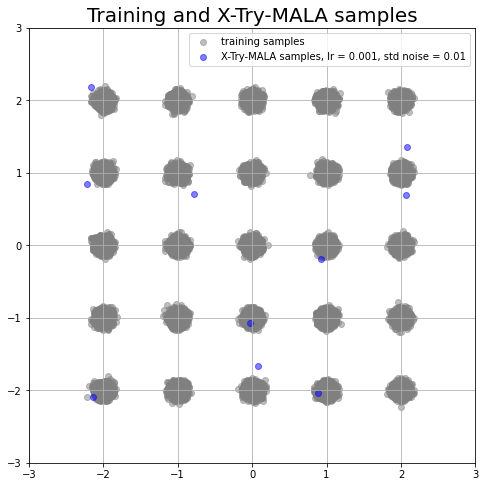

In [175]:
x_try_mala = G(y1_last).data.cpu().numpy()
mode = 'X-Try-MALA'
params = f'lr = {step_lr}, std noise = {eps_std}'
plot_fake_data_mode(x_try_mala, X_train, mode, path_to_save, 
                    scaler = scaler,
                    params = params)

In [ ]:
def xtry_mala_dynamics_v2(y0, y1, gen, dis, alpha, n_steps, step_lr, eps_std, N):
    #print(f"y1 = {y1}")
    #print(f"y0 = {y0}")
    y0_arr = [y0.detach().clone()]
    y1_arr = [y1.detach().clone()]
    batch_size, z_dim = y0.shape[0], y0.shape[1]
    loc = torch.zeros(z_dim).to(gen.device)
    scale = torch.ones(z_dim).to(gen.device)
    normal = Normal(loc, scale)

    for _ in tqdm(range(n_steps)):
        #print(f"step = {_}")
        #print(f"y1 = {y1}")
        #print(f"y0 = {y0}")
        U = np.random.randint(N)
        #print(f"U = {U}")
        Z0 = y0.unsqueeze(1).repeat(1, N, 1)
        Z1 = y1.unsqueeze(1).repeat(1, N, 1)
        noise = normal.sample([batch_size, N])
        #print(f"noise_std = {eps_std*noise}")
        
        E_g_j, grad_g_j = e_grad(y0, normal, gen, dis, alpha, ret_e=True)
        g_j = y0 - step_lr * grad_g_j
        g_j = g_j.data
        #print(f"g_j = {g_j}")
        
        g_j_N = g_j.unsqueeze(1).repeat(1, N, 1)
        Z1 = g_j_N + eps_std*noise
        Z1[:, U, :] = y1
        #print(f"Z1 = {Z1}")
        #print(f"Z0 = {Z0}")
        for i in range(batch_size):
            #print(f"num start = {i}")
            first = Z0[i].data
            second = Z1[i].data
            first.requires_grad_(True)
            second.requires_grad_(True)
            
            log_weight = compute_log_weight(first, second, gen, dis, normal, alpha, step_lr, eps_std)
            max_logs = torch.max(log_weight, dim = 0)[0]
            log_weight = log_weight - max_logs
            weight = torch.exp(log_weight)
            sum_weight = torch.sum(weight, dim = 0)

            weight = weight/sum_weight
            #print(f"weight = {weight}")

            indices = torch.multinomial(weight, 1)
            #print(f"indice = {indices}")
            y1[i] = Z1[i][indices]
        
        with torch.no_grad():
            y1 = y1.data
            #print(z)
        y1.requires_grad_(True)
        y1_arr.append(y1.detach().clone())
        #print(f"y1 = {y1}")
            
        E_y1, grad_y1 = e_grad(y1, normal, gen, dis, alpha, ret_e=True)
        add_noise = eps_std*noise[:, U, :]
        #print(f"add noise = {add_noise}")
        y0 = y1 - step_lr * grad_y1 + add_noise
        #print(f"y0 = {y0}") 
        y0 = y0.data
        y0.requires_grad_(True)
        y0_arr.append(y0.detach().clone())
        #print(f"y0 = {y0}")        
        #print("-----------------------")
        
    #print(f"y1_arr = {y1_arr}")
    #print(f"y0_arr = {y0_arr}")
    return y0_arr, y1_arr

# MALA

In [12]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [73]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 5000
z = G.make_hidden(batchsize)
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

In [74]:
acceptence.mean()/n_steps

tensor(0.6859, device='cuda:0')

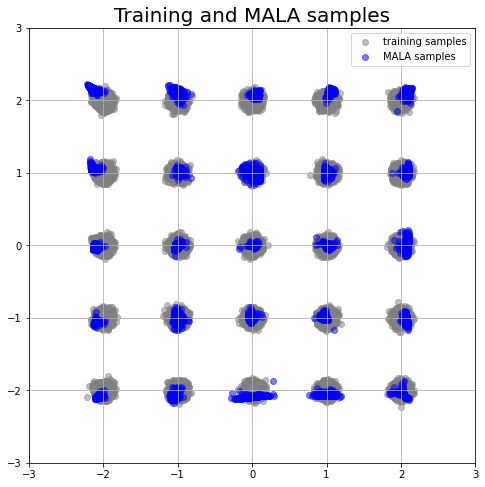

In [75]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

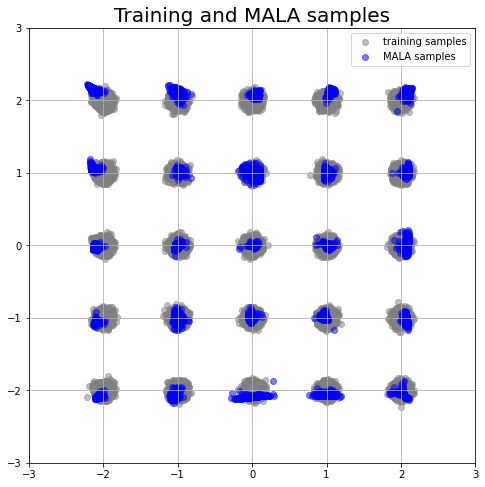

In [76]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [69]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-2
eps_std = 1e-2
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(0.0108, device='cuda:0')


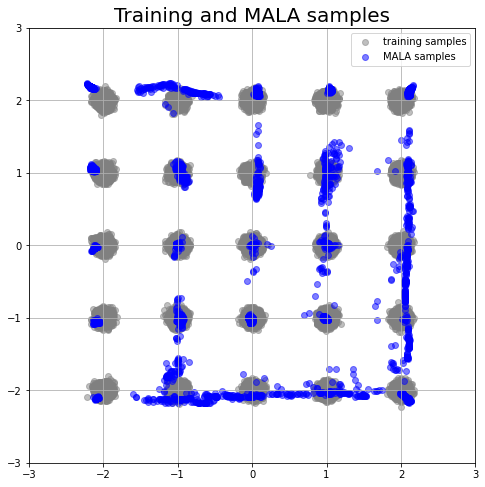

In [70]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

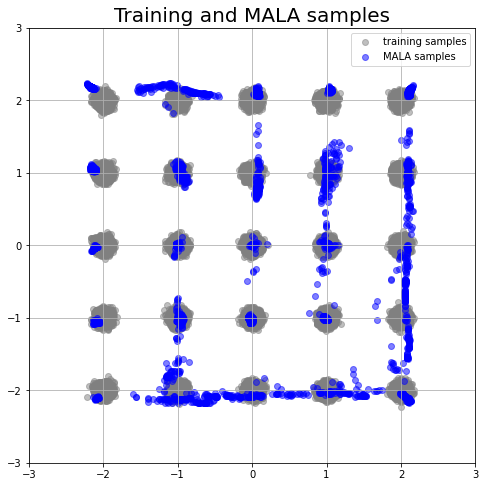

In [71]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [64]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-3
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(0.8191, device='cuda:0')


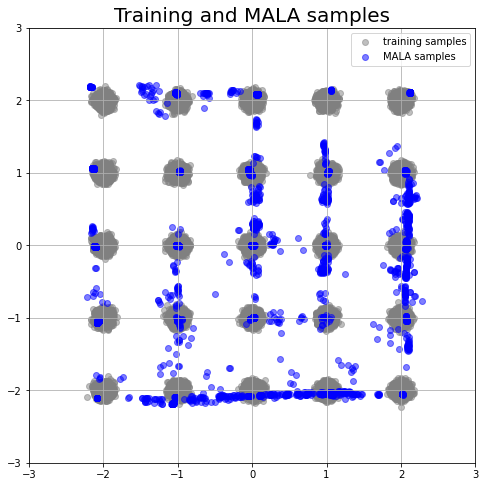

In [67]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

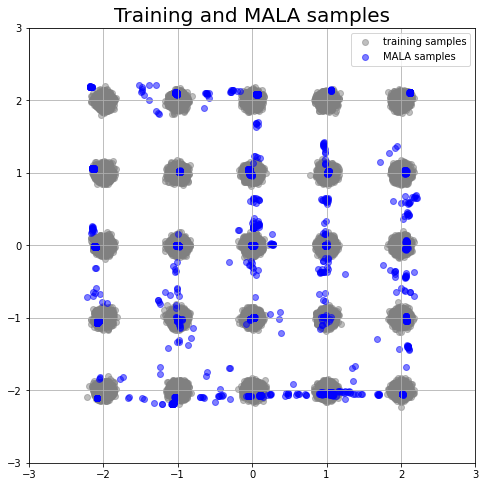

In [65]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [32]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-1
eps_std = 1e-3
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(4.0000e-08, device='cuda:0')


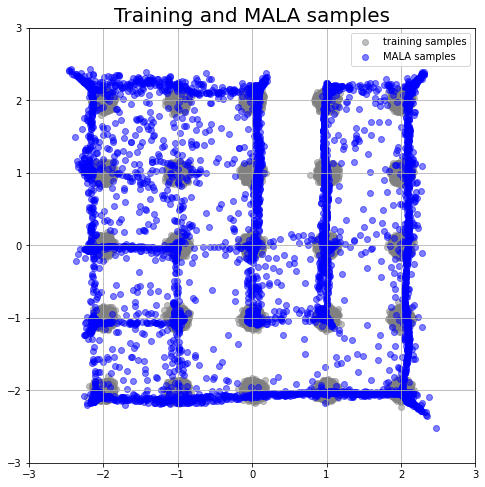

In [35]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [37]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
print(new_samples.shape)

torch.Size([2])


In [38]:
new_samples

tensor([0.5974, 1.1048], device='cuda:0')

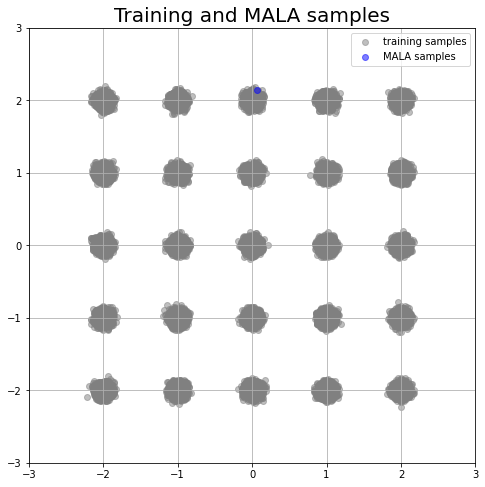

In [40]:
fake_mala = G(new_samples.view((1, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [41]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-1
eps_std = 1e-2
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(8.0000e-08, device='cuda:0')


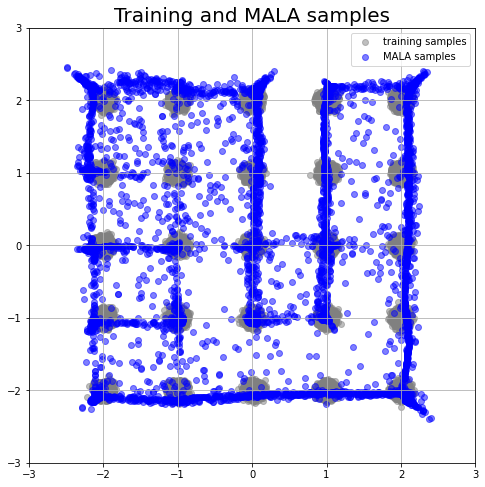

In [42]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [46]:
mask_new_samples

tensor([[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]], device='cuda:0')

In [47]:
z_sp[-1]

tensor([[-3.1241,  1.6574],
        [ 0.4826, -0.1967],
        [ 1.6863,  0.8296],
        ...,
        [ 1.0031, -0.5051],
        [ 0.5871, -0.8596],
        [ 1.2122,  0.5603]], device='cuda:0')

In [48]:
new_samples

tensor([ 0.9699,  2.0739,  0.4184, -1.5051], device='cuda:0')

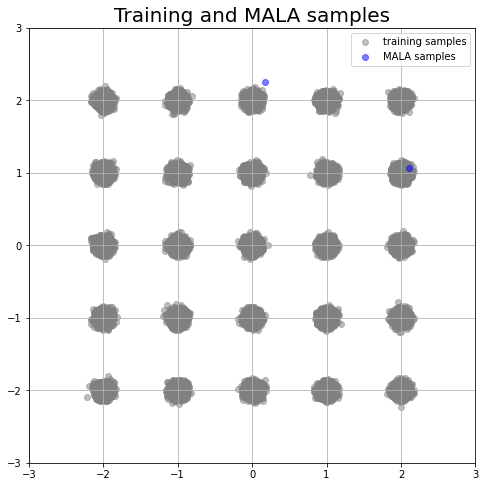

In [50]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

In [51]:
batchsize = 5000
alpha = 1.0
step_lr = 1e-2
eps_std = 1e-4
n_steps = 5000
z = G.make_hidden(batchsize)
z_copy = z.clone().detach()
z.requires_grad_(True)
z_sp, acceptence = mala_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)
print(acceptence.mean().data/n_steps)

tensor(0.0004, device='cuda:0')


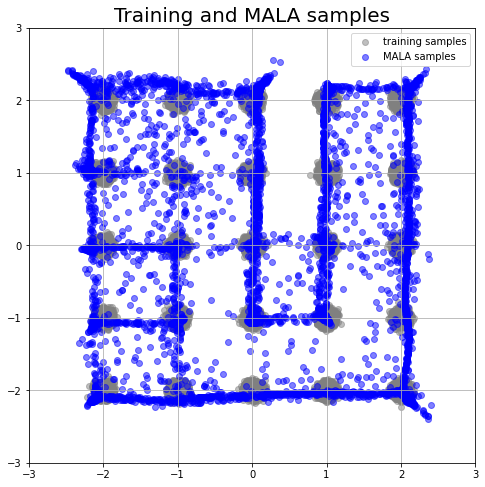

In [52]:
mala_samples = z_sp[-1]
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

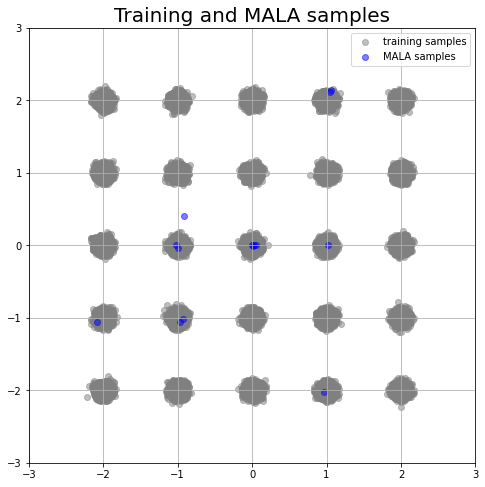

In [53]:
mask_new_samples = (z_copy != z_sp[-1])
new_samples = z_sp[-1][mask_new_samples]
num_samples = new_samples.shape[0] // 2
fake_mala = G(new_samples.view((num_samples, 2))).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

# NUTS

In [60]:
def calculate_energy(params, generator, discriminator, P, normalize_to_0_1, is_dict):
    if is_dict:
        params = params['points']
    generator_points = generator(params)
    if normalize_to_0_1:
        GAN_part = -discriminator(generator_points).view(-1)
    else:
        sigmoid_GAN_part = discriminator(generator_points)
        GAN_part = -(torch.log(sigmoid_GAN_part) - \
                     torch.log1p(-sigmoid_GAN_part)).view(-1)

    prior_part = -torch.sum(P.log_prob(params), dim=-1)
    return GAN_part + prior_part

In [61]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

G = G.to(device)
D = D.to(device)

for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [62]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(D.device)
normal = Normal(loc, scale)

normalize_to_0_1 = True
is_dict = True

cur_calculate_energy = partial(calculate_energy, 
                               generator = G,
                               discriminator = D,
                               P = normal,
                               normalize_to_0_1 = normalize_to_0_1,
                               is_dict = is_dict)

In [63]:
kernel = NUTS(potential_fn = cur_calculate_energy)

In [64]:
num_samples = 10
batchsize = 2

init_params = G.make_hidden(batchsize).to(device)
init_params = {'points': init_params}

In [65]:
cur_calculate_energy(init_params)

tensor([2.7370, 3.3742])

In [66]:
mcmc = MCMC(kernel = kernel, 
            num_samples = num_samples, 
            initial_params = init_params,
            num_chains = batchsize)

Warmup [1]:   0%|          | 0/20 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/20 [00:00, ?it/s]

In [67]:
mcmc.run()

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork

In [24]:
device = 'cpu'
target = torch.distributions.Normal(loc=torch.tensor([10., 10.], device=device, dtype=torch.float32),
                                    scale=torch.tensor([1., 1.], device=device, dtype=torch.float32))

In [25]:
def potential_fn(samples):
    return -target.log_prob(samples['points']).sum(-1)

In [26]:
nuts = NUTS(potential_fn=potential_fn)

In [27]:
num_chains = 6
initial_params = {'points': torch.randn((num_chains, 2), dtype=torch.float32, device=device)}

In [52]:
potential_fn(initial_params)

tensor([ 89.7230,  88.2194,  87.5004,  99.5866, 120.7469, 113.0349])

In [28]:
mcmc = MCMC(kernel=nuts, num_samples=100, warmup_steps=100,
            initial_params=initial_params, num_chains=num_chains)

Warmup [1]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/200 [00:00, ?it/s]

In [29]:
mcmc.run()

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

[ERROR LOG CHAIN:2]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

[ERROR LOG CHAIN:3]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 96, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/api.py", line 108, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/lib/python3.9/site-packages/pyro/infer/mcmc/hmc.py", line 306, in setup
    z_grads, potential_energy = potential_grad(self.potential_fn, z)
  File "/usr/lib/python3.9/site-packages/pyro/ops/integrator.py", line 84, in potential_grad
    grads = grad(potential_energy, z_nodes)
  File "/usr/lib/python3.9/site-packages/torch/autograd/__init__.py", line 202, in grad
    return Variable._execution_engine.run_backward(
RuntimeError: Unable to handle autograd's threadin

RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork